<font style='font-size:2.5em'>**Part I: Data Cleaning and Outlier Detection** </font>

## **Import Libraries**

First, we import the necessary libraries.

In [97]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Load Data

In [98]:
df_germany = pd.read_excel('../data/imf_GERMANY_data.xlsx')

# Load the second XLSX file into a DataFrame
df_us = pd.read_excel('../data/imf_US_data.xlsx')

In [99]:
df_germany.rename(columns={'International Financial Statistics (IFS)': 'Month'}, inplace=True)

# Rename the unnamed columns based on the provided names
new_column_names = [
    'Month',
    'Economic Activity, Industrial Production, Index',
    'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
    'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
    'Prices, Consumer Price Index, All items, Index'
]
df_germany.columns = new_column_names
df_germany = df_germany.drop([0, 1])

In [100]:
df_us.rename(columns={'International Financial Statistics (IFS)': 'Month'}, inplace=True)

# Rename the unnamed columns based on the provided names
new_column_names1 = [
    'Month',
    'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
    'Prices, Consumer Price Index, All items, Index'
]

df_us.columns = new_column_names1
df_us = df_us.drop([0, 1,])

df_germany['Country'] = 'Germany'
df_us['Country'] = 'US'

# Merge the two DataFrames
merged_df = pd.concat([df_germany, df_us], ignore_index=True)


In [101]:
columns = ['Month', 'Country', 'Economic Activity, Industrial Production, Index',
           'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
           'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
           'Prices, Consumer Price Index, All items, Index']

merged_df = merged_df[columns]


## **Calculating Exchange Rate Growth**


- **Nominal Exchange Rate Growth (%)**  
  - This is calculated as the **percentage change** in the nominal exchange rate compared to the previous month.
  - **Formula:**  
    ```
    Nominal Exchange Rate Growth (%) = ((Current Month Nominal Exchange Rate - Previous Month Nominal Exchange Rate) / Previous Month Nominal Exchange Rate) * 100
    ```
  - This helps us track how the exchange rate fluctuates over time.

- **Real Exchange Rate Calculation**  
  - The **Real Exchange Rate (RER)** adjusts the nominal exchange rate by accounting for differences in price levels (inflation) between Germany and the US.
  - **US is used as the base** for comparison.
  - **Formula:**  
    ```
    Real Exchange Rate = Nominal Exchange Rate * (CPI (US) / CPI (Germany))
    ```
  - This measure provides a better understanding of the actual purchasing power of the currency, adjusted for inflation.



In [102]:
df_germany = merged_df[merged_df['Country'] == 'Germany']
df_us = merged_df[merged_df['Country'] == 'US']

# Reset index for both DataFrames
df_germany.reset_index(drop=True, inplace=True)
df_us.reset_index(drop=True, inplace=True)

# Calculate the ratio of US CPI to Germany CPI
cpi_ratio = df_us['Prices, Consumer Price Index, All items, Index'].values / df_germany['Prices, Consumer Price Index, All items, Index'].values

# Calculate the monthly growth in the nominal exchange rate for Germany
df_germany['Real Exchange Rate'] = cpi_ratio * df_germany['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate']

# Add the new variable to the original merged DataFrame
merged_df.loc[merged_df['Country'] == 'Germany', 'Real Exchange Rate'] = df_germany['Real Exchange Rate']

# Rename the column
merged_df.rename(columns={'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate': 'Nominal Exchange Rate'}, inplace=True)



/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/3081440155.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_germany['Real Exchange Rate'] = cpi_ratio * df_germany['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate']


In [103]:
# Calculate the percentage change in the nominal exchange rate only for Germany
merged_df.loc[merged_df["Country"] == "Germany", "Nominal Exchange Rate Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Nominal Exchange Rate"].pct_change() * 100
)

# Calculate the percentage change in the real exchange rate only for Germany
merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate"].pct_change() * 100
)

/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/4228870552.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Nominal Exchange Rate"].pct_change() * 100
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/4228870552.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate"].pct_change() * 100


##  Construct the Real Exchange Rate Index 
- Base Year as Dec 1990 



In [104]:
# Filter for Germany and find the Real Exchange Rate for December 1990
rer_dec_1990 = merged_df.loc[(merged_df["Country"] == "Germany") & 
                             (merged_df["Month"] == "Dec 1990"), 
                             "Real Exchange Rate"].values[0]

# Construct the RER Index for Germany
merged_df.loc[merged_df["Country"] == "Germany", "RER_Index"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate"] / rer_dec_1990
)

# Compute Monthly Inflation Growth (%) for both US and Germany

In [105]:
merged_df["Monthly Inflation Growth (%)"] = merged_df.groupby("Country")[
    "Prices, Consumer Price Index, All items, Index"
].pct_change() * 100

pd.reset_option("display.max_rows")


# Compute Industrial Production Growth (%)
 Monthly Industrial Production Growth (%) and Industrial Production YoY Growth (%)

In [106]:
# Compute Monthly Industrial Production Growth (%) for only Germany
merged_df.loc[merged_df["Country"] == "Germany", "Monthly Industrial Production Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change() * 100
)

# Compute Yearly Industrial Production Growth (%) for only Germany (12-month difference)
merged_df.loc[merged_df["Country"] == "Germany", "Industrial Production YoY Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change(periods=12) * 100
)

/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/2070185427.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change() * 100
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/2070185427.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change(periods=12) * 100


## Compute the International Reserves Index for Germany and US 

In [107]:
# Find the base value of international reserves for January 1960 separately for Germany & US
germany_base_reserves = merged_df.loc[
    (merged_df["Country"] == "Germany") & (merged_df["Month"] == "Jan 1960"),
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"
].values[0]

us_base_reserves = merged_df.loc[
    (merged_df["Country"] == "US") & (merged_df["Month"] == "Jan 1960"),
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"
].values[0]

# Compute the International Reserves Index for Germany
merged_df.loc[merged_df["Country"] == "Germany", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] / germany_base_reserves * 100
)

# Compute the International Reserves Index for the US
merged_df.loc[merged_df["Country"] == "US", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] = (
    merged_df.loc[merged_df["Country"] == "US", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] / us_base_reserves * 100
)

merged_df.rename(
    columns={"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": 
             "International Reserves Index"}, 
    inplace=True
)


In [108]:
# List of columns to drop
columns_to_drop = [
    'Economic Activity, Industrial Production, Index',
    
'Prices, Consumer Price Index, All items, Index',
    'Real Exchange Rate',
]

# Drop the columns from the DataFrame
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')


In [109]:
merged_df

,Month,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,Dec 1959,Germany,4.2,101.848342,NaN,NaN,1.713301,NaN,NaN,NaN
1,Jan 1960,Germany,4.2,100.0,0.0,-0.340136,1.707474,0.0,-4.019729,NaN
2,Feb 1960,Germany,4.2,101.740143,0.0,0.914640,1.723091,-0.568147,-0.488181,NaN
3,Mar 1960,Germany,4.2,105.128964,0.0,0.000000,1.723091,0.0,3.743868,NaN
4,Apr 1960,Germany,4.2,110.837171,0.0,-0.229943,1.719129,0.571393,6.470881,NaN
...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,NaN,367.39208,NaN,NaN,NaN,0.920245,NaN,NaN
742,Sep 1990,US,NaN,372.584941,NaN,NaN,NaN,0.835866,NaN,NaN
743,Oct 1990,US,NaN,385.751982,NaN,NaN,NaN,0.602864,NaN,NaN
744,Nov 1990,US,NaN,386.716715,NaN,NaN,NaN,0.224719,NaN,NaN


## **Detect Outliers**

In [110]:
# Define a function to detect strict (fewer) outliers
def detect_outliers_strict(df, column, iqr_threshold=2.5, z_threshold=3.0):  
    # Compute IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - iqr_threshold * IQR
    upper_bound_iqr = Q3 + iqr_threshold * IQR
    
    # Compute Z-score bounds
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound_z = mean - z_threshold * std_dev
    upper_bound_z = mean + z_threshold * std_dev

    # Ensure fewer values are flagged (outliers must violate both conditions)
    return (df[column] < lower_bound_iqr) & (df[column] < lower_bound_z) | \
           (df[column] > upper_bound_iqr) & (df[column] > upper_bound_z)

# Apply function to numeric columns
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
outlier_locations = []

for col in numeric_columns:
    outliers = detect_outliers_strict(merged_df, col, iqr_threshold=2.5, z_threshold=3.0)
    
    # Store row index, month, column, and outlier value
    for index in merged_df[outliers].index:
        outlier_locations.append((index, merged_df.loc[index, "Month"], col, merged_df.loc[index, col]))

# Convert outlier locations to a DataFrame for easier viewing
outliers_df = pd.DataFrame(outlier_locations, columns=["Row Index", "Month", "Column", "Outlier Value"])

# Display detected outliers with the Month column
print("Detected Outliers with Month Information:")
print(outliers_df)


Detected Outliers with Month Information:
    Row Index     Month                                Column  Outlier Value
0         119  Nov 1969      Nominal Exchange Rate Growth (%)      -8.500000
1         162  Jun 1973      Nominal Exchange Rate Growth (%)      -7.669997
2         163  Jul 1973      Nominal Exchange Rate Growth (%)      -9.474501
3         167  Nov 1973      Nominal Exchange Rate Growth (%)       6.913703
4         254  Feb 1981      Nominal Exchange Rate Growth (%)       6.774258
5         119  Nov 1969         Real Exchange Rate Growth (%)      -8.217983
6         145  Jan 1972         Real Exchange Rate Growth (%)      -7.990670
7         162  Jun 1973         Real Exchange Rate Growth (%)      -7.554545
8         163  Jul 1973         Real Exchange Rate Growth (%)      -9.603880
9         243  Mar 1980         Real Exchange Rate Growth (%)       7.022401
10        254  Feb 1981         Real Exchange Rate Growth (%)       7.043635
11        102  Jun 1968  Industria

## **Replace Certain Outliers with NaN**

In [111]:
# Convert 'Month' to extract year (assuming format 'Jan 1973')
outliers_df['Year'] = outliers_df['Month'].str[-4:].astype(int)

# Define valid year range (±5 years from 1973)
valid_year_range = (outliers_df['Year'] >= 1968) & (outliers_df['Year'] <= 1978)

# Filter out only those outliers that are outside the valid range
outliers_to_replace = outliers_df[~valid_year_range]  # Invert the filter (~)

# Apply NaN to these specific outliers in merged_df
for _, row in outliers_to_replace.iterrows():
    merged_df.loc[row["Row Index"], row["Column"]] = np.nan

# Display summary of changes
print("Outliers replaced with NaN (Years outside 1968-1978):")
print(outliers_to_replace)


Outliers replaced with NaN (Years outside 1968-1978):
    Row Index     Month                            Column  Outlier Value  Year
4         254  Feb 1981  Nominal Exchange Rate Growth (%)       6.774258  1981
9         243  Mar 1980     Real Exchange Rate Growth (%)       7.022401  1980
10        254  Feb 1981     Real Exchange Rate Growth (%)       7.043635  1981


In [112]:
merged_df.loc[254] #check whether the value has been replaced with NaN


Month                                          Feb 1981
Country                                         Germany
Nominal Exchange Rate                            2.1436
International Reserves Index                1139.353417
Nominal Exchange Rate Growth (%)                    NaN
Real Exchange Rate Growth (%)                       NaN
RER_Index                                      1.187437
Monthly Inflation Growth (%)                   0.780227
Monthly Industrial Production Growth (%)       3.293824
Industrial Production YoY Growth (%)          -3.395566
Name: 254, dtype: object

## **Deal With Missing Values**

In [113]:
# List of columns where missing values should NOT be handled
columns_to_exclude = [
    "Nominal Exchange Rate Growth (%)",
    "Real Exchange Rate Growth (%)",
    "RER_Index",
    "Monthly Industrial Production Growth (%)",
    "Industrial Production YoY Growth (%)"
]

# Separate data for US (for exclusion in missing value handling)
us_mask = merged_df["Country"] == "US"

# Step 1: Apply interpolation **only to allowed columns** (excluding US for the specific calculations)
for col in merged_df.select_dtypes(include=[np.number]).columns:
    if col not in columns_to_exclude:
        merged_df.loc[~us_mask, col] = merged_df.loc[~us_mask, col].interpolate(method='linear')

# Step 2: Forward-fill and Backward-fill missing values, but **only for allowed columns**
for col in merged_df.select_dtypes(include=[np.number]).columns:
    if col not in columns_to_exclude:
        merged_df[col].ffill(inplace=True)  # Forward fill
        merged_df[col].bfill(inplace=True)  # Backward fill

# Step 3: Special Handling for First Row NaNs
merged_df.fillna(method="bfill", inplace=True)  # Backward fill first row NaNs

# Step 4: As a last resort, fill remaining NaNs with column means (except excluded columns)
for col in merged_df.select_dtypes(include=[np.number]).columns:
    if col not in columns_to_exclude:
        merged_df[col].fillna(merged_df[col].mean(), inplace=True)

/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/3976157605.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method="bfill", inplace=True)  # Backward fill first row NaNs
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/3976157605.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(method="bfill", inplace=True)  # Backward fill first row NaNs
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/3976157605.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method

In [114]:
merged_df

,Month,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,Dec 1959,Germany,4.200000,101.848342,0.0,-0.340136,1.713301,0.000000,-4.019729,10.900123
1,Jan 1960,Germany,4.200000,100.000000,0.0,-0.340136,1.707474,0.000000,-4.019729,10.900123
2,Feb 1960,Germany,4.200000,101.740143,0.0,0.914640,1.723091,-0.568147,-0.488181,10.900123
3,Mar 1960,Germany,4.200000,105.128964,0.0,0.000000,1.723091,0.000000,3.743868,10.900123
4,Apr 1960,Germany,4.200000,110.837171,0.0,-0.229943,1.719129,0.571393,6.470881,10.900123
...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,2.938981,367.392080,NaN,NaN,NaN,0.920245,NaN,NaN
742,Sep 1990,US,2.938981,372.584941,NaN,NaN,NaN,0.835866,NaN,NaN
743,Oct 1990,US,2.938981,385.751982,NaN,NaN,NaN,0.602864,NaN,NaN
744,Nov 1990,US,2.938981,386.716715,NaN,NaN,NaN,0.224719,NaN,NaN


In [115]:
print("Number of missing values per column:")
print(merged_df.isna().sum())  # Shows NaN count for each column


Number of missing values per column:
Month                                         0
Country                                       0
Nominal Exchange Rate                         0
International Reserves Index                  0
Nominal Exchange Rate Growth (%)            373
Real Exchange Rate Growth (%)               373
RER_Index                                   373
Monthly Inflation Growth (%)                  0
Monthly Industrial Production Growth (%)    373
Industrial Production YoY Growth (%)        373
dtype: int64


In [116]:
# Convert "Month" column to datetime format (assuming format like "Jan 1960")
merged_df["Date"] = pd.to_datetime(merged_df["Month"], format="%b %Y")

# Drop the old "Month" column (optional)
merged_df.drop(columns=["Month"], inplace=True)

# Sort the DataFrame by the new Date column (optional but recommended)
merged_df.sort_values("Date", inplace=True)

# Reset index (optional)
merged_df.reset_index(drop=True, inplace=True)

# Reorder columns: Move "Date" to the first position
cols = ["Date"] + [col for col in merged_df.columns if col != "Date"]
merged_df = merged_df[cols]



In [117]:
# Rename the column
merged_df.rename(columns={"RER_Index": "Real Exchange Rate Index"}, inplace=True)
# Sort by 'Country' first (Germany first, then US), then by 'Date'
merged_df = merged_df.sort_values(by=["Country", "Date"], ascending=[True, True])

# Reset index (optional)
merged_df.reset_index(drop=True, inplace=True)

merged_df


,Date,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,1959-12-01,Germany,4.200000,101.848342,0.0,-0.340136,1.713301,0.000000,-4.019729,10.900123
1,1960-01-01,Germany,4.200000,100.000000,0.0,-0.340136,1.707474,0.000000,-4.019729,10.900123
2,1960-02-01,Germany,4.200000,101.740143,0.0,0.914640,1.723091,-0.568147,-0.488181,10.900123
3,1960-03-01,Germany,4.200000,105.128964,0.0,0.000000,1.723091,0.000000,3.743868,10.900123
4,1960-04-01,Germany,4.200000,110.837171,0.0,-0.229943,1.719129,0.571393,6.470881,10.900123
...,...,...,...,...,...,...,...,...,...,...
741,1990-08-01,US,2.938981,367.392080,NaN,NaN,NaN,0.920245,NaN,NaN
742,1990-09-01,US,2.938981,372.584941,NaN,NaN,NaN,0.835866,NaN,NaN
743,1990-10-01,US,2.938981,385.751982,NaN,NaN,NaN,0.602864,NaN,NaN
744,1990-11-01,US,2.938981,386.716715,NaN,NaN,NaN,0.224719,NaN,NaN


<font style='font-size:2.5em'>**Part II: Data Visualisation** </font>

<font style='font-size:1.25em'>**5.2.1 Exchange Rate and International Reserve Graphs** </font>

Germany's exit from the Bretton Woods system occurred in March 1973, and we will be reflecting this in the visualistions below showing: 
-  The monthly growth in the nominal exchange rate.
- The level of the nominal exchange rate.
-  The monthly growth in the real exchange rate.
-  The real exchange rate index

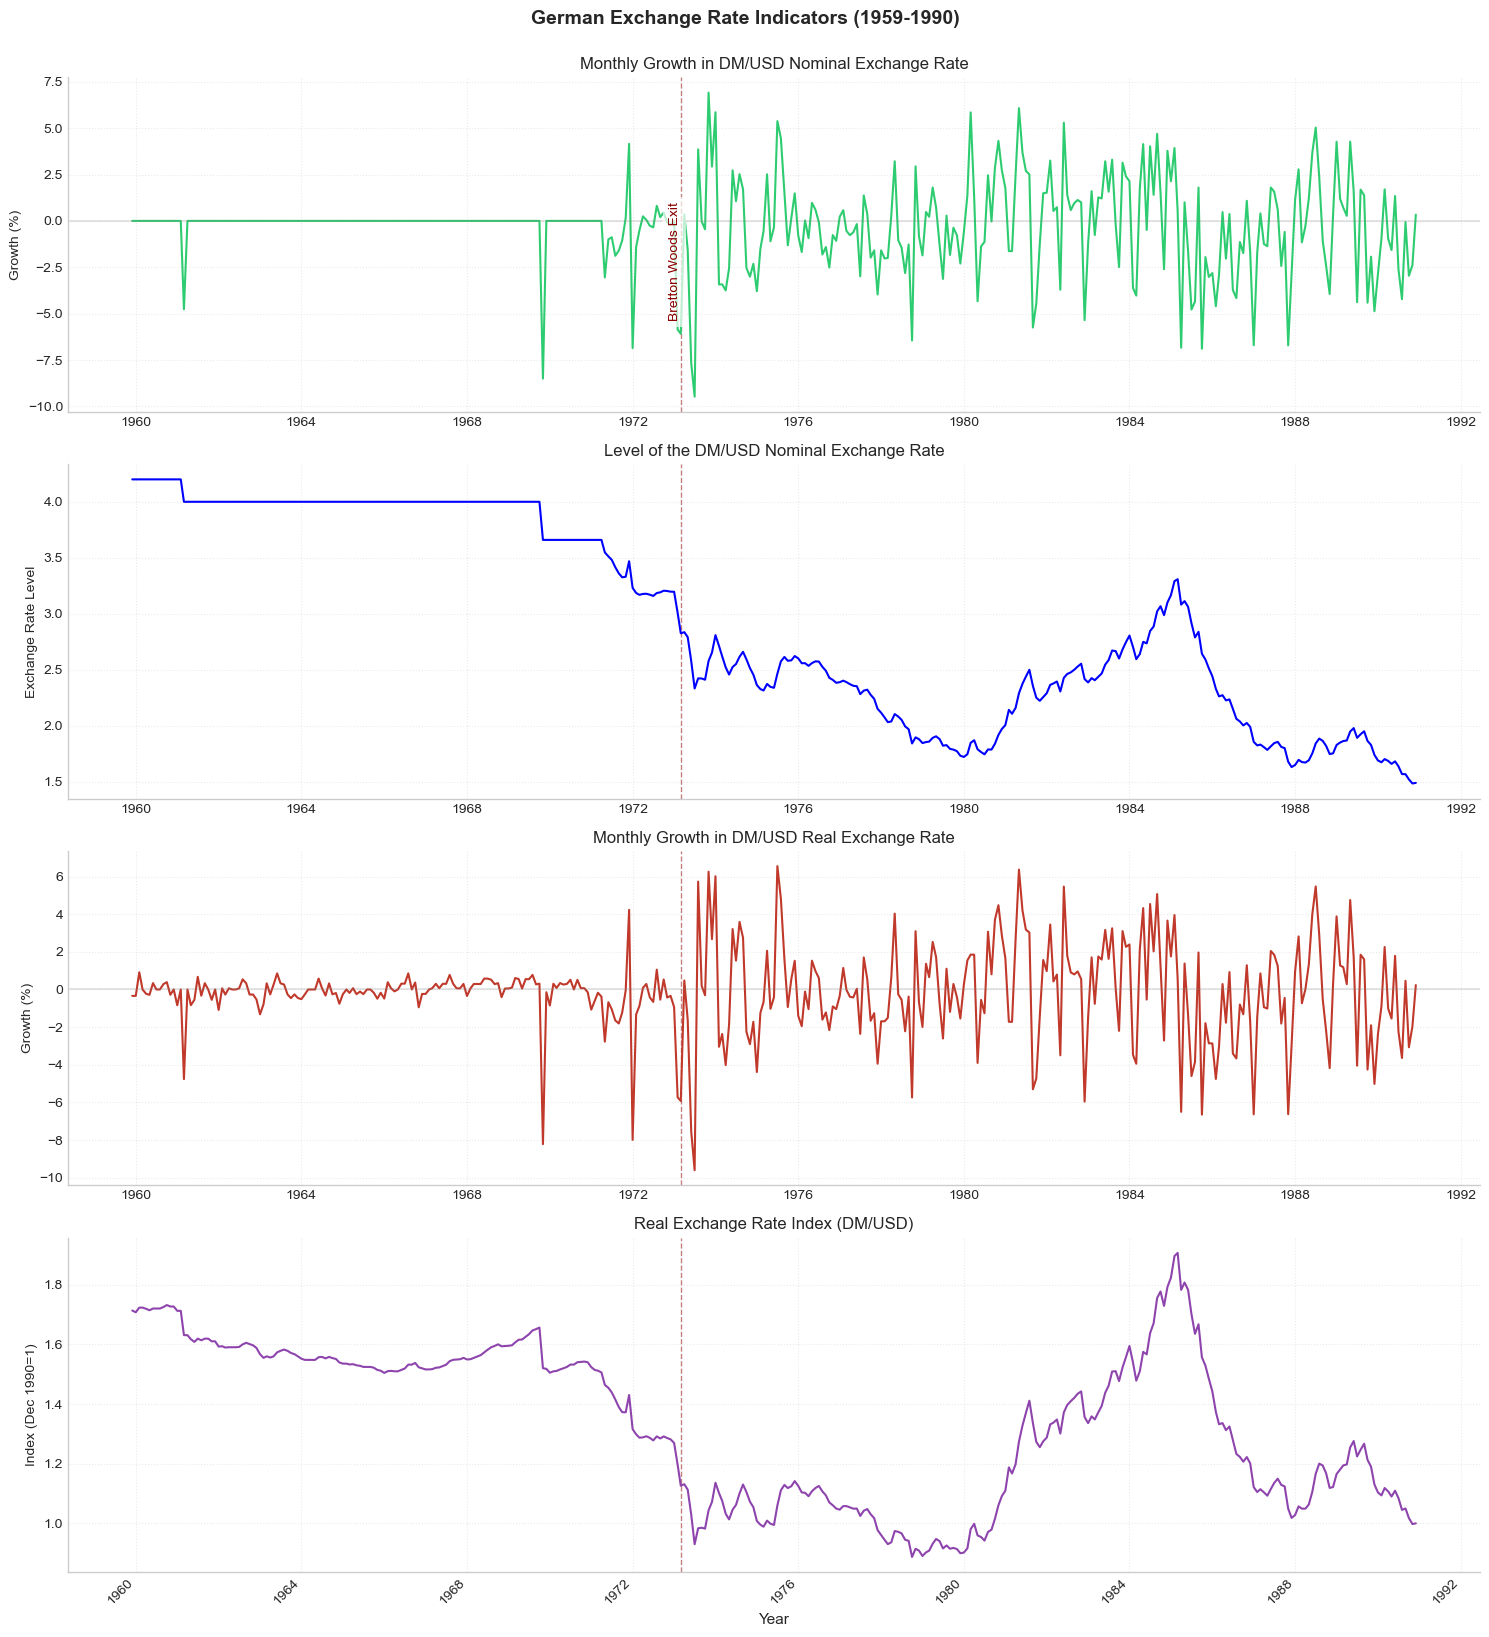

In [118]:
# Filter data for Germany only
germany_df = merged_df[merged_df["Country"] == "Germany"]

# Define Bretton Woods exit date
bretton_woods_exit = pd.to_datetime('1973-03-01')

# Set style and figure
plt.style.use('seaborn-v0_8-whitegrid')  
fig, axs = plt.subplots(4, 1, figsize=(15, 16))

# Common formatting for all subplots
for ax in axs:
    ax.grid(True, linestyle=':', alpha=0.4)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add Bretton Woods marker
    ax.axvline(x=bretton_woods_exit, color='darkred', linestyle='--', alpha=0.5, linewidth=1)
    
    # Only add text annotation to the top plot
    if ax == axs[0]:
        ax.text(bretton_woods_exit, ax.get_ylim()[1], 
                'Bretton Woods Exit', 
                rotation=90, 
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=10,
                color='darkred',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Plot 1: Monthly Growth in Nominal Exchange Rate
axs[0].plot(germany_df["Date"], germany_df["Nominal Exchange Rate Growth (%)"], 
            color="#2ecc71", linewidth=1.5)
axs[0].set_title("Monthly Growth in DM/USD Nominal Exchange Rate", fontsize=12)
axs[0].set_ylabel("Growth (%)")
axs[0].axhline(y=0, color='gray', linestyle='-', alpha=0.2)

# Plot 2: Level of Nominal Exchange Rate 
axs[1].plot(germany_df["Date"], germany_df["Nominal Exchange Rate"], 
            color="blue", linewidth=1.5)
axs[1].set_title("Level of the DM/USD Nominal Exchange Rate", fontsize=12)
axs[1].set_ylabel("Exchange Rate Level")

# Plot 3: Monthly Growth in Real Exchange Rate
axs[2].plot(germany_df["Date"], germany_df["Real Exchange Rate Growth (%)"], 
            color="#c0392b", linewidth=1.5)
axs[2].set_title("Monthly Growth in DM/USD Real Exchange Rate", fontsize=12)
axs[2].set_ylabel("Growth (%)")
axs[2].axhline(y=0, color='gray', linestyle='-', alpha=0.2)

# Plot 4: Real Exchange Rate Index
axs[3].plot(germany_df["Date"], germany_df["Real Exchange Rate Index"], 
            color="#8e44ad", linewidth=1.5)
axs[3].set_title("Real Exchange Rate Index (DM/USD)", fontsize=12)
axs[3].set_ylabel("Index (Dec 1990=1)")

# X-axis formatting
axs[3].set_xlabel("Year", fontsize=11)
for ax in axs:
    ax.tick_params(axis='both', labelsize=10)

# Rotate x-axis labels and adjust layout
plt.setp(axs[-1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

# Add main title with more space
fig.suptitle("German Exchange Rate Indicators (1959-1990)", 
             y=1.02, fontsize=14, fontweight='bold')

plt.show()

These time series graphs show  the monthly indexed value of international reserves for Germany and the US from January 1960 until the exit of the US from Bretton Woods.


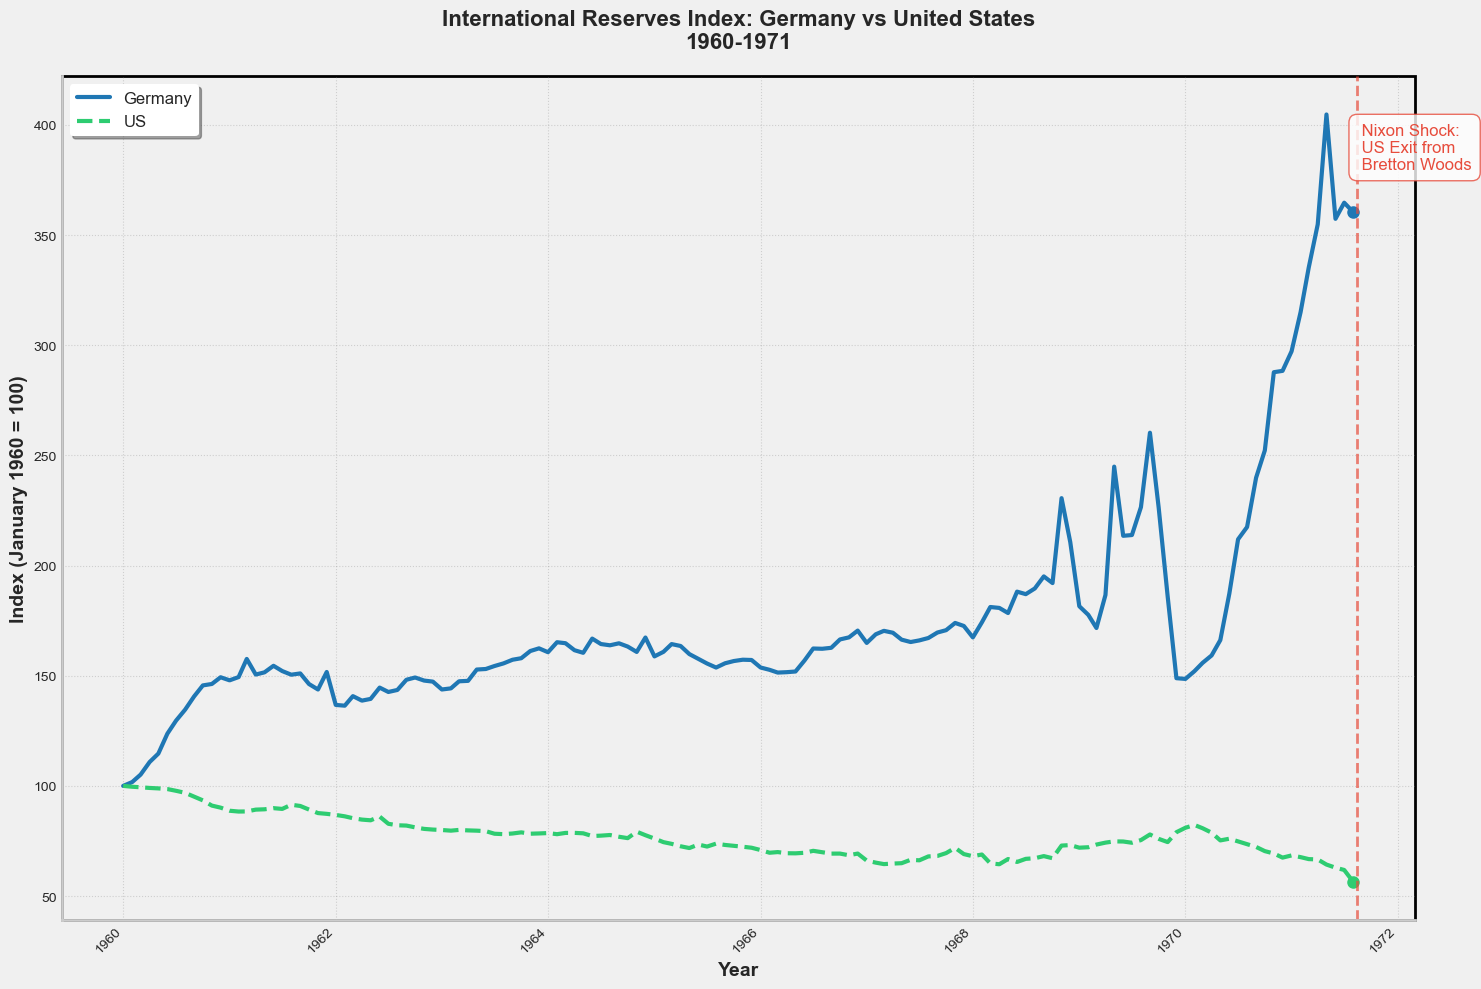

In [119]:
# Define the date range
start_date = pd.to_datetime('1960-01-01')
us_exit_date = pd.to_datetime('1971-08-15')  # Nixon Shock - US Exit from Bretton Woods

# Filter data for the specific time period and countries
mask = (merged_df['Date'] >= start_date) & (merged_df['Date'] <= us_exit_date)
plot_data = merged_df[mask].copy()

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure and axis with a specific background color
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Define better colors
colors = {'Germany': '#1f77b4', 'US': '#2ecc71'}
styles = {'Germany': '-', 'US': '--'}

# Plot data for both countries with enhanced styling
for country in ['Germany', 'US']:
    country_data = plot_data[plot_data['Country'] == country]
    line = ax.plot(country_data['Date'], 
                  country_data['International Reserves Index'],
                  label=country,
                  linewidth=3,
                  linestyle=styles[country],
                  color=colors[country])
    
    # Add end points markers
    ax.plot(country_data['Date'].iloc[-1], 
            country_data['International Reserves Index'].iloc[-1],
            marker='o',
            markersize=8,
            color=colors[country])

# Add vertical line for US exit with enhanced styling
ax.axvline(x=us_exit_date, color='#e74c3c', linestyle='--', alpha=0.7, linewidth=2)

# Add annotation with better formatting
ax.text(us_exit_date, ax.get_ylim()[1] * 0.95, 
        ' Nixon Shock:\n US Exit from\n Bretton Woods', 
        rotation=0,
        verticalalignment='top',
        horizontalalignment='left',
        color='#e74c3c',
        fontsize=12,
        bbox=dict(facecolor='white', 
                 edgecolor='#e74c3c',
                 boxstyle='round,pad=0.5',
                 alpha=0.8))

# Enhance grid
ax.grid(True, linestyle=':', alpha=0.3, color='gray')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Customize title and labels with better fonts
plt.title('International Reserves Index: Germany vs United States\n1960-1971', 
          fontsize=16, 
          pad=20, 
          fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Index (January 1960 = 100)', fontsize=14, fontweight='bold')

# Enhance legend
legend = plt.legend(fontsize=12, 
                   frameon=True,
                   facecolor='white',
                   edgecolor='none',
                   shadow=True,
                   loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add a subtle box around the plot
ax.set_frame_on(True)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(2)

# Adjust layout
plt.tight_layout()


plt.show()

<font style='font-size:1.25em'>**5.2.2 Inflation and Industrial Production Graphs**</font>

- *Graph 1:* Monthly inflation for Germany 

- *Graph 2:* The difference between monthly inflation in Germany and the US (plotted as a single graph showing the difference).

- *Graph 3:* Monthly growth in industrial production for Germany (a line graph showing month-to-month changes).

- *Graph 4:* Growth in industrial production for Germany compared to 12 months ago (a line graph showing year-over-year comparisons for each month).

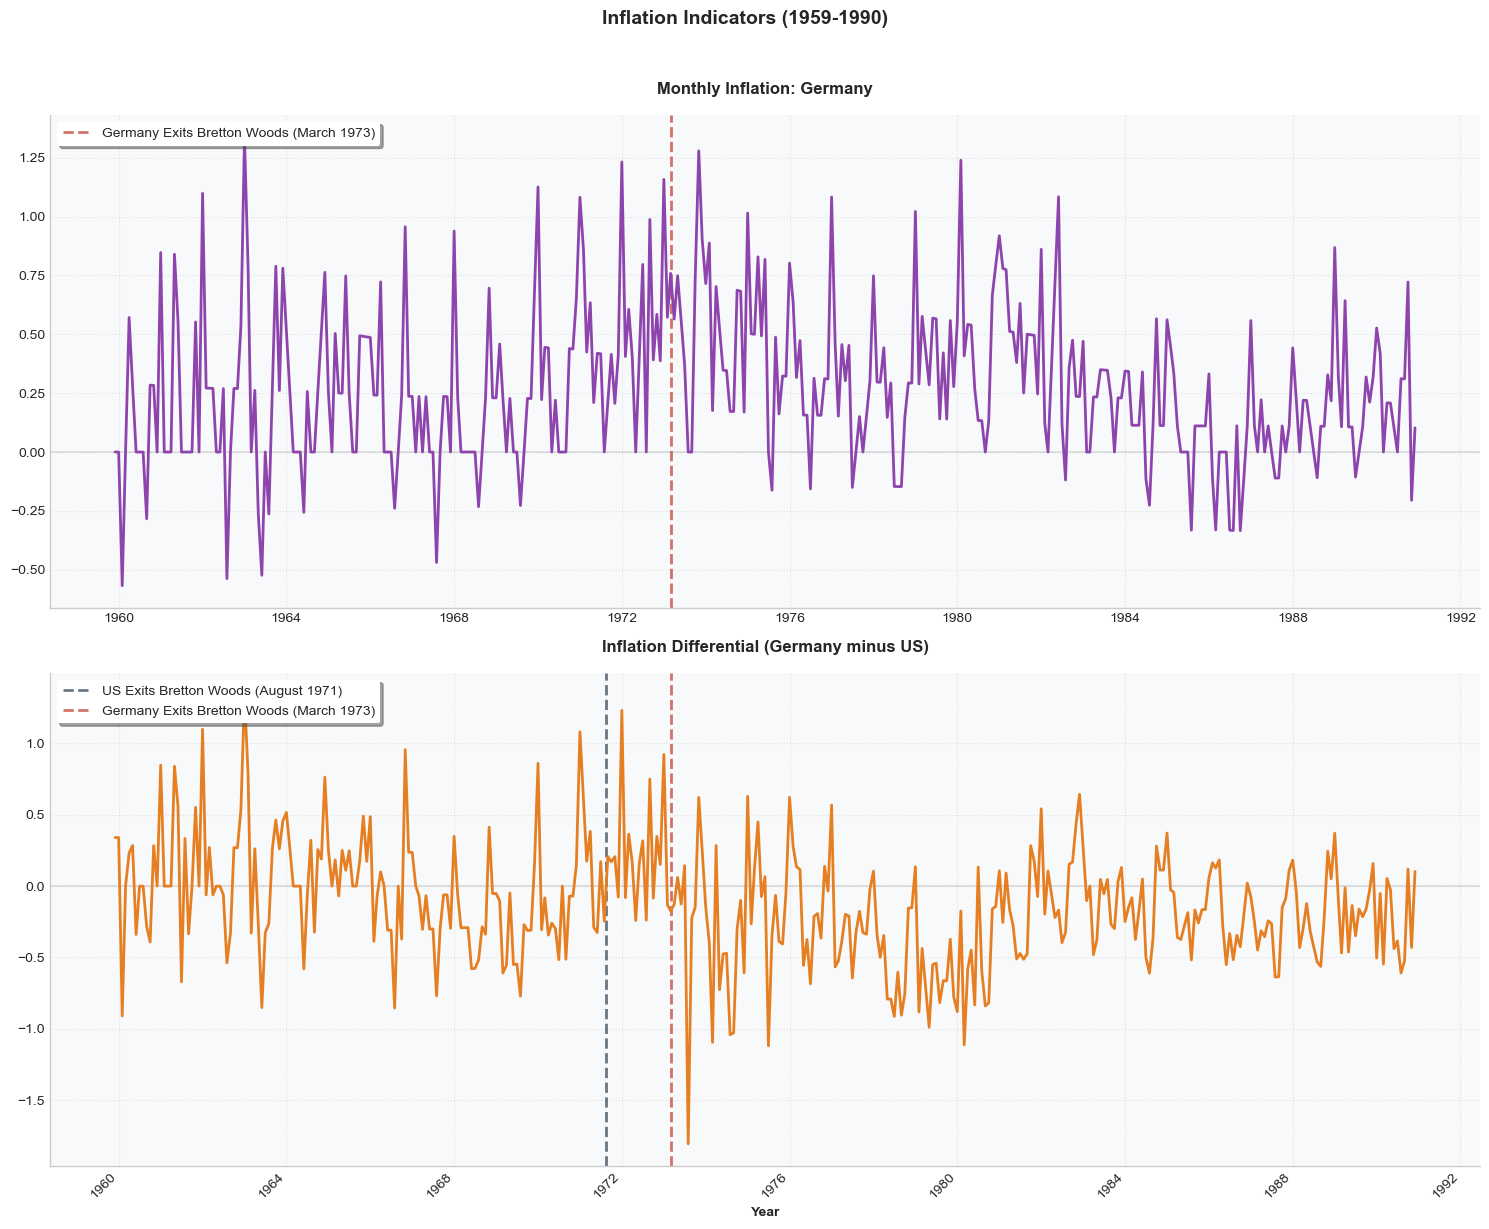

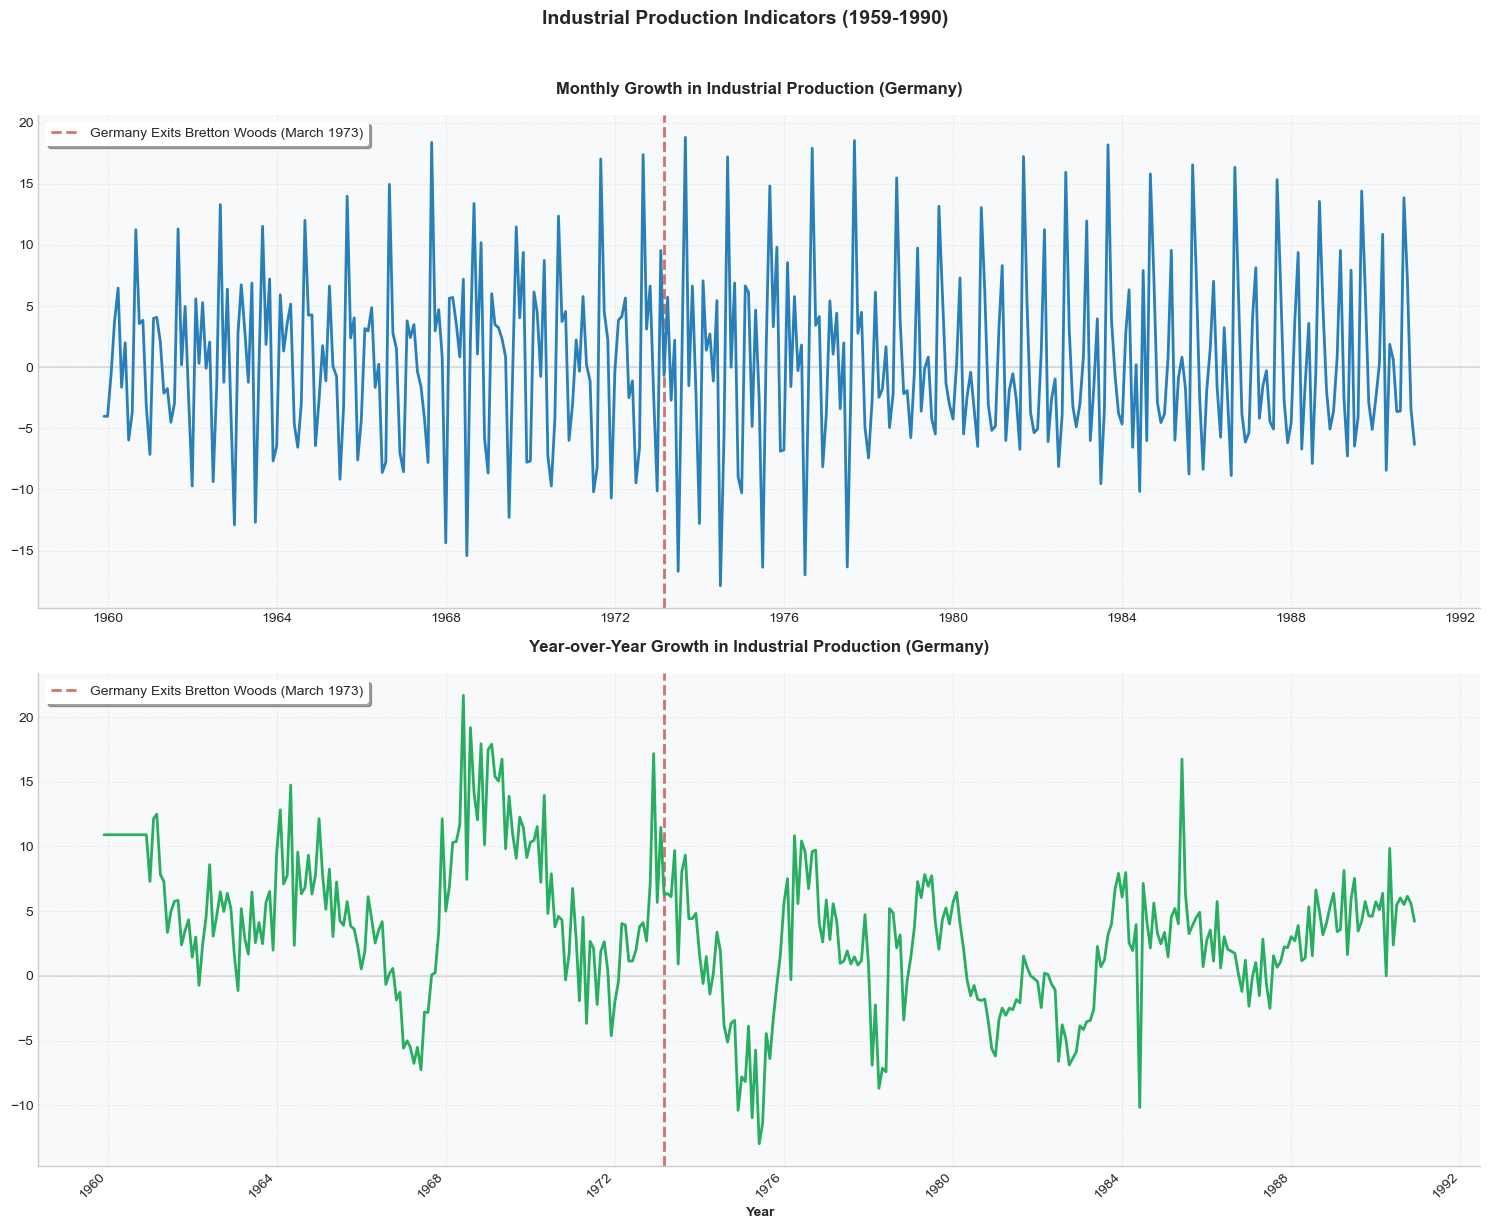

In [120]:
# Create two figures: one for inflation, one for production
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(15, 12))

# Define Bretton Woods exit dates
germany_exit = pd.to_datetime('1973-03-01')
us_exit = pd.to_datetime('1971-08-15')  # Nixon Shock

# Define colors
colors = {
    'germany_line': '#8e44ad',    # Purple for Germany data
    'diff_line': '#e67e22',       # Orange for differential
    'monthly_prod': '#2980b9',    # Blue for monthly production
    'yearly_prod': '#27ae60',     # Green for yearly production
    'us_exit': '#2c3e50',         # Dark blue-gray for US exit
    'germany_exit': '#c0392b',    # Dark red for Germany exit
    'grid': '#ecf0f1'             # Light gray for grid
}

# Common formatting for all plots
for ax in [ax1, ax2, ax3, ax4]:
    # Add subtle grid
    ax.grid(True, linestyle=':', alpha=0.2, color='gray')
    ax.set_facecolor('#f8f9fa')  # Light background
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.2)
    ax.tick_params(axis='both', labelsize=10)
    
    if ax == ax2:  # For inflation differential plot only
        # Add both exit lines
        line_us = ax.axvline(x=us_exit, color=colors['us_exit'], linestyle='--', 
                           alpha=0.7, linewidth=2, label='US Exits Bretton Woods (August 1971)')
        line_germany = ax.axvline(x=germany_exit, color=colors['germany_exit'], linestyle='--', 
                                alpha=0.7, linewidth=2, label='Germany Exits Bretton Woods (March 1973)')
        # Add combined legend
        ax.legend(handles=[line_us, line_germany], 
                 fontsize=10, frameon=True, facecolor='white', 
                 edgecolor='none', shadow=True, loc='upper left')
    else:  # For other plots
        # Add only Germany's exit line
        line = ax.axvline(x=germany_exit, color=colors['germany_exit'], linestyle='--', 
                         alpha=0.7, linewidth=2, label='Germany Exits Bretton Woods (March 1973)')
        ax.legend(fontsize=10, frameon=True, facecolor='white', 
                 edgecolor='none', shadow=True, loc='upper left')

# Graph 1: Monthly Inflation (Germany only)
germany_data = merged_df[merged_df['Country'] == 'Germany']
ax1.plot(germany_data['Date'], 
         germany_data['Monthly Inflation Growth (%)'],
         color=colors['germany_line'],
         linewidth=2)

# Graph 2: Inflation Differential
germany_inf = merged_df[merged_df['Country'] == 'Germany']['Monthly Inflation Growth (%)']
us_inf = merged_df[merged_df['Country'] == 'US']['Monthly Inflation Growth (%)']
inflation_diff = germany_inf.values - us_inf.values

ax2.plot(merged_df[merged_df['Country'] == 'Germany']['Date'], 
         inflation_diff,
         color=colors['diff_line'],
         linewidth=2)

# Graph 3: Monthly Industrial Production Growth
ax3.plot(germany_data['Date'], 
         germany_data['Monthly Industrial Production Growth (%)'],
         color=colors['monthly_prod'],
         linewidth=2)

# Graph 4: Year-over-Year Industrial Production Growth
ax4.plot(germany_data['Date'], 
         germany_data['Industrial Production YoY Growth (%)'],
         color=colors['yearly_prod'],
         linewidth=2)

# Set titles and labels with improved styling
for ax, title in zip([ax1, ax2, ax3, ax4], 
                    ['Monthly Inflation: Germany',
                     'Inflation Differential (Germany minus US)',
                     'Monthly Growth in Industrial Production (Germany)',
                     'Year-over-Year Growth in Industrial Production (Germany)']):
    ax.set_title(title, fontsize=12, pad=15, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, fontweight='bold')

# Add x-axis labels and rotate dates
for ax in [ax2, ax4]:
    ax.set_xlabel('Year', fontsize=10, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add main titles with improved styling
fig1.suptitle('Inflation Indicators (1959-1990)', 
              y=1.02, fontsize=14, fontweight='bold')
fig2.suptitle('Industrial Production Indicators (1959-1990)', 
              y=1.02, fontsize=14, fontweight='bold')

# Set figure background color
for fig in [fig1, fig2]:
    fig.patch.set_facecolor('white')
    fig.tight_layout()

plt.show()

ANALYSIS

<font style='font-size:1.25em'>**5.2.3 Comparison Statistics & Visualisation** </font>



Standard Deviations Before and After Bretton Woods:
                          Variable  Pre-BW  Post-BW  Ratio (Post/Pre)
      Nominal Exchange Rate Growth   0.864    2.840             3.286
         Real Exchange Rate Growth   0.931    2.862             3.074
                    Inflation Rate   0.341    0.307             0.898
            Inflation Differential   0.414    0.367             0.886
Industrial Production Growth (12m)   5.553    4.687             0.844


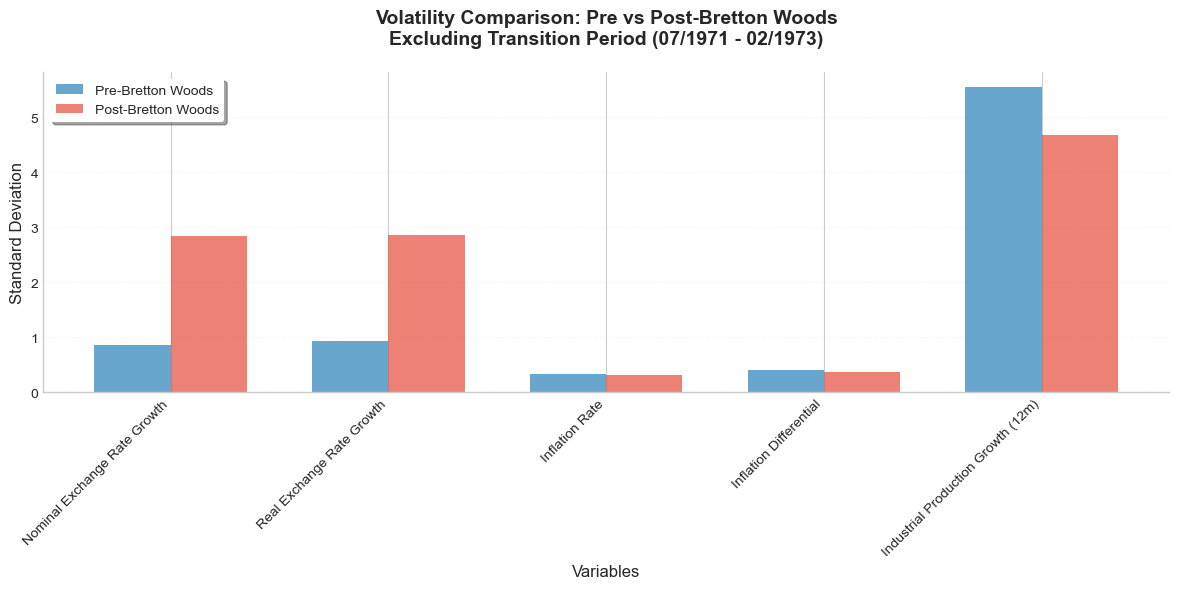

In [121]:
# Define periods
pre_bw = pd.to_datetime('1971-06-30')
post_bw = pd.to_datetime('1973-03-01')

# Filter for Germany and US separately
germany_data = merged_df[merged_df['Country'] == 'Germany'].copy()
us_data = merged_df[merged_df['Country'] == 'US'].copy()

# Calculate inflation differential by aligning dates
germany_data['Inflation_Differential'] = (
    germany_data['Monthly Inflation Growth (%)'] - 
    us_data['Monthly Inflation Growth (%)'].values
)

# Variables to analyze
variables = {
    'Nominal Exchange Rate Growth (%)': 'Nominal Exchange Rate Growth',
    'Real Exchange Rate Growth (%)': 'Real Exchange Rate Growth',
    'Monthly Inflation Growth (%)': 'Inflation Rate',
    'Inflation_Differential': 'Inflation Differential',
    'Industrial Production YoY Growth (%)': 'Industrial Production Growth (12m)'
}

# Calculate standard deviations
results = []
for var, name in variables.items():
    pre_std = germany_data[germany_data['Date'] <= pre_bw][var].std()
    post_std = germany_data[germany_data['Date'] >= post_bw][var].std()
    ratio = post_std / pre_std
    results.append({
        'Variable': name,
        'Pre-BW': pre_std,
        'Post-BW': post_std,
        'Ratio (Post/Pre)': ratio
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Display formatted table
print("\nStandard Deviations Before and After Bretton Woods:")
print(results_df.round(3).to_string(index=False))

# Create bar chart
plt.figure(figsize=(12, 6))

# Plot bars
x = np.arange(len(variables))
width = 0.35

plt.bar(x - width/2, results_df['Pre-BW'], width, 
        label='Pre-Bretton Woods', color='#2980b9', alpha=0.7)
plt.bar(x + width/2, results_df['Post-BW'], width, 
        label='Post-Bretton Woods', color='#e74c3c', alpha=0.7)

# Customize chart
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.title('Volatility Comparison: Pre vs Post-Bretton Woods\nExcluding Transition Period (07/1971 - 02/1973)', 
          pad=20, fontsize=14, fontweight='bold')

# Rotate and align the tick labels so they look better
plt.xticks(x, [variables[key] for key in variables.keys()], 
           rotation=45, ha='right')

# Add legend
plt.legend(frameon=True, facecolor='white', 
          edgecolor='none', shadow=True)

# Add grid
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

**Why exclude data from 07/1971 - 02/1973?**

This transition period is excluded because:

1) It represents a time of unusual market uncertainty and volatility
2) The Bretton Woods system was effectively breaking down
3) Countries were adjusting their policies and markets were adapting


Including it would skew the comparison between stable pre- and post-Bretton Woods period, as the period represents neither a true fixed nor floating exchange rate regime

Below is a plot to show the yearly standard deviation for inflation, inflation difference, and industrial production growth from 1960 to 1990.

* The difference in the dates between Germany and US leaving the Bretton Woods system is denoted by the transition period

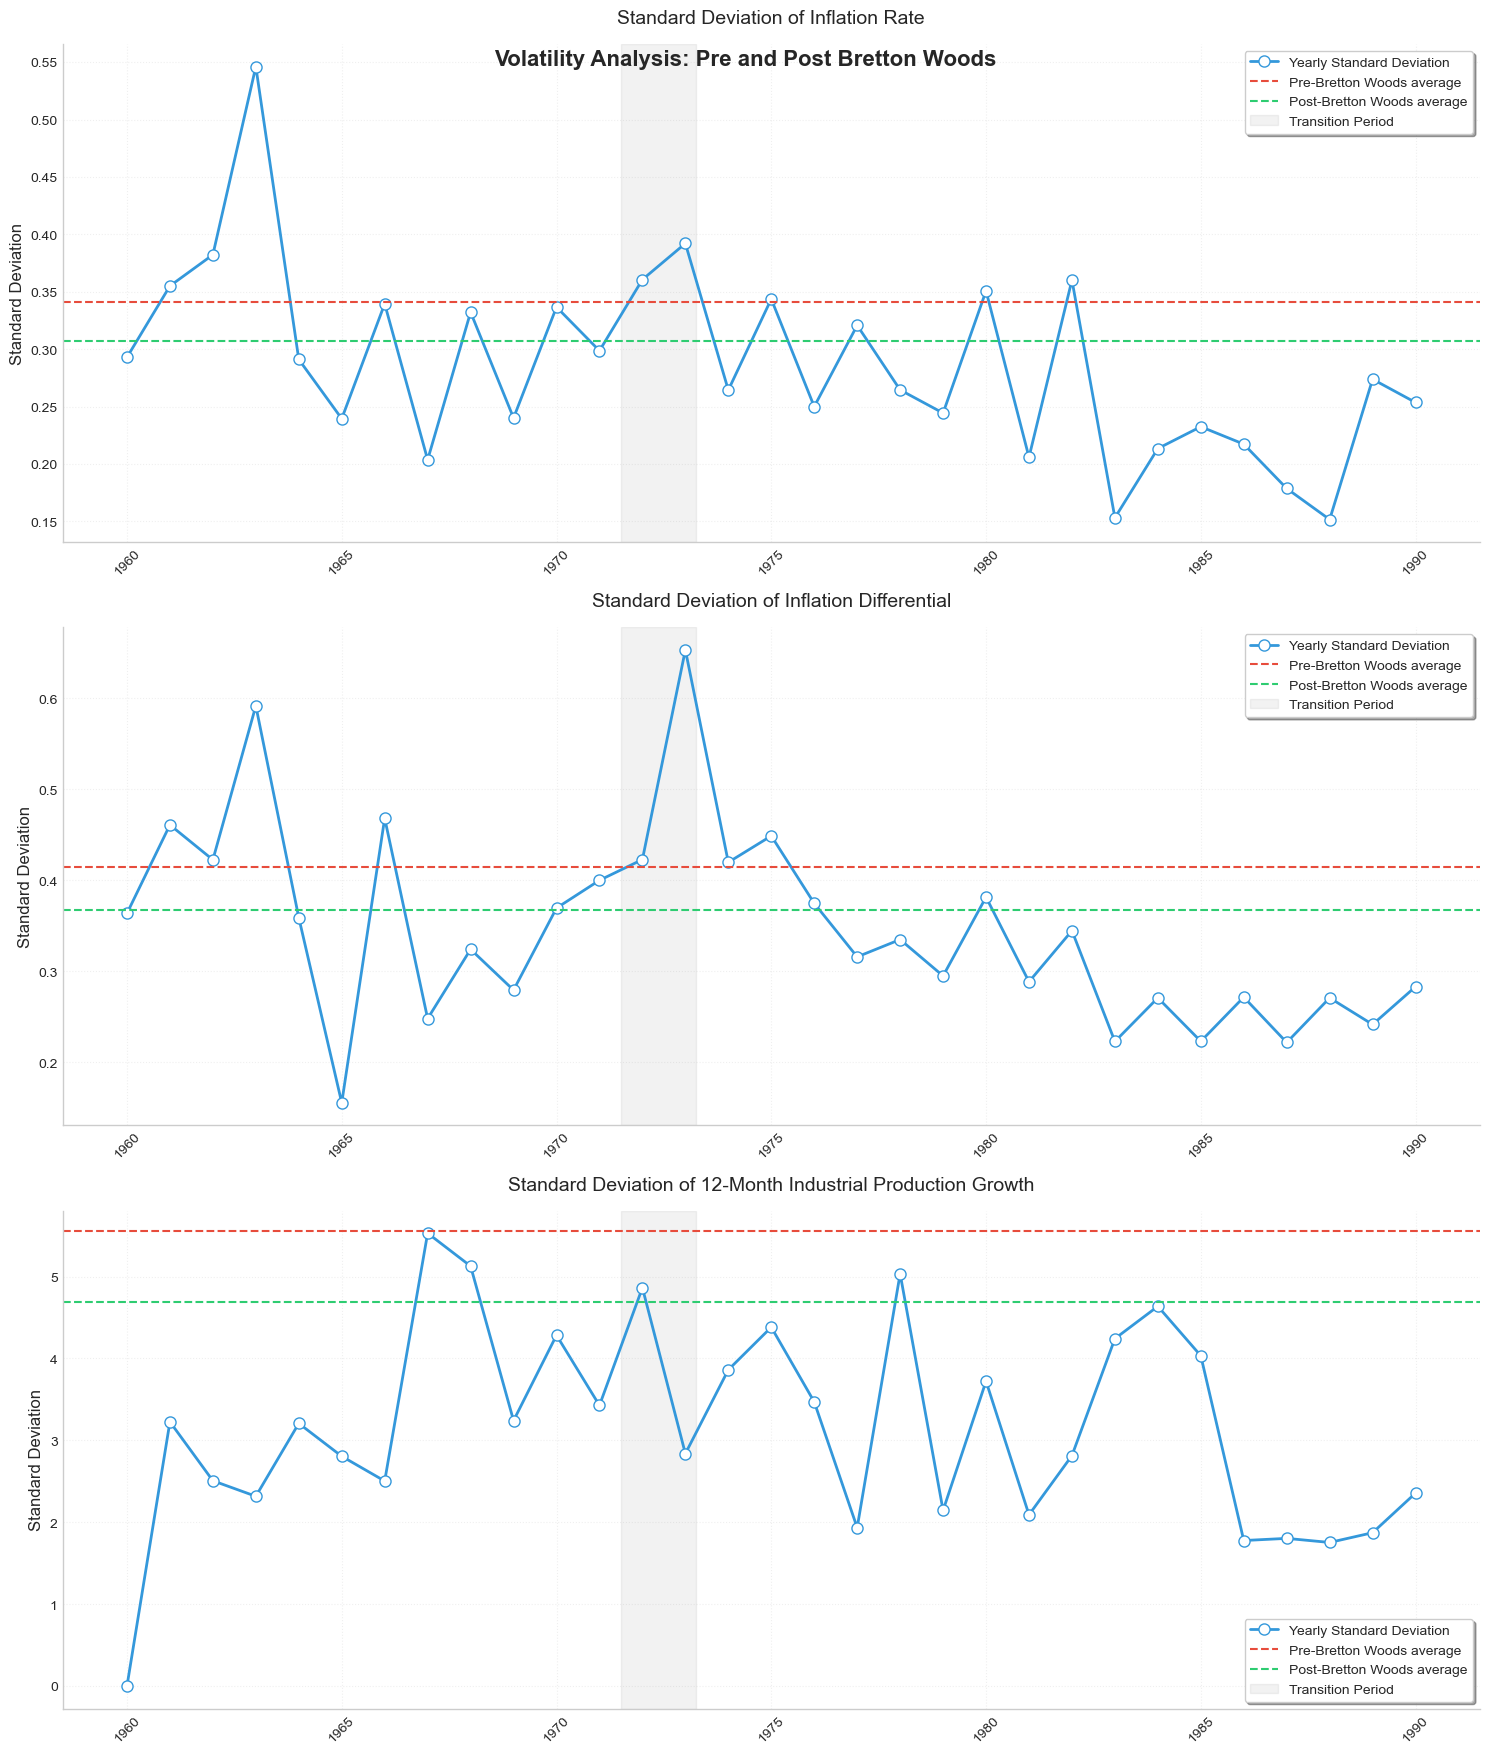

In [122]:
variables = {
    'Monthly Inflation Growth (%)': 'Inflation Rate',
    'Inflation_Differential': 'Inflation Differential',
    'Industrial Production YoY Growth (%)': '12-Month Industrial Production Growth'
}

# Calculate inflation differential
germany_data = merged_df[merged_df['Country'] == 'Germany'].copy()
germany_data['Inflation_Differential'] = (
    germany_data['Monthly Inflation Growth (%)'] - 
    merged_df[merged_df['Country'] == 'US']['Monthly Inflation Growth (%)'].values
)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Common formatting for all plots
for ax in axes:
    ax.grid(True, linestyle=':', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', rotation=45)

# Plot each variable
for idx, (var, title) in enumerate(variables.items()):
    # Calculate statistics
    yearly_std = germany_data.groupby(germany_data['Date'].dt.year)[var].std()
    pre_std = germany_data[germany_data['Date'] <= pre_bw][var].std()
    post_std = germany_data[germany_data['Date'] >= post_bw][var].std()
    
    # Create plot
    axes[idx].plot(yearly_std.index, yearly_std.values, 'o-', color='#3498db', 
                  linewidth=2, markersize=8, markerfacecolor='white', 
                  label='Yearly Standard Deviation')
    axes[idx].axhline(y=pre_std, color='#e74c3c', linestyle='--', 
                      label='Pre-Bretton Woods average')
    axes[idx].axhline(y=post_std, color='#2ecc71', linestyle='--', 
                      label='Post-Bretton Woods average')
    axes[idx].axvspan(1971.5, 1973.25, color='gray', alpha=0.1, 
                      label='Transition Period')
    
    # Add labels
    axes[idx].set_title(f'Standard Deviation of {title}', fontsize=14, pad=15)
    axes[idx].set_ylabel('Standard Deviation', fontsize=12)
    axes[idx].legend(frameon=True, facecolor='white', shadow=True)

# Final details
plt.suptitle('Volatility Analysis: Pre and Post Bretton Woods', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

<font style='font-size:1.25em'>**5.2.4 Regression Analysis** </font>

In [123]:
# Create 6-month period identifier
germany_data = merged_df[merged_df['Country'] == 'Germany'].copy()
germany_data['Period'] = germany_data['Date'].dt.year.astype(str) + '-' + \
                        ((germany_data['Date'].dt.month <= 6).map({True: 'H1', False: 'H2'}))

# Calculate inflation differential
germany_data['Inflation_Differential'] = (
    germany_data['Monthly Inflation Growth (%)'] - 
    merged_df[merged_df['Country'] == 'US']['Monthly Inflation Growth (%)'].values
)

# Variables to analyze
variables = {
    'Real Exchange Rate Growth (%)': 'Real Exchange Rate Growth',
    'Inflation_Differential': 'Inflation Differential',
    'Industrial Production YoY Growth (%)': '12-Month Industrial Production Growth'
}

# Calculate 6-month standard deviations
results = {}
for var in variables.keys():
    results[var] = germany_data.groupby('Period')[var].std()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.index.name = 'Period'

# Display first few periods
print("Standard Deviations by 6-month Period:")
print(results_df.head(10).round(3))


Standard Deviations by 6-month Period:
         Real Exchange Rate Growth (%)  Inflation_Differential  \
Period                                                           
1959-H2                            NaN                     NaN   
1960-H1                          0.484                   0.483   
1960-H2                          0.240                   0.240   
1961-H1                          1.802                   0.423   
1961-H2                          0.441                   0.442   
1962-H1                          0.449                   0.454   
1962-H2                          0.408                   0.408   
1963-H1                          0.799                   0.804   
1963-H2                          0.350                   0.351   
1964-H1                          0.364                   0.364   

         Industrial Production YoY Growth (%)  
Period                                         
1959-H2                                   NaN  
1960-H1                 

In [124]:
# Manual check for a specific period (e.g., 1970-H1)
print("\nManual Check for 1970-H1:")
check_period = '1970-H1'
for var, name in variables.items():
    # Get the data for the specific period
    period_data = germany_data[
        (germany_data['Date'].dt.year == 1970) & 
        (germany_data['Date'].dt.month <= 6)
    ][var]
    
    # Calculate standard deviation manually
    manual_std = period_data.std()
    
    # Get the value from our results
    calculated_std = results_df.loc[check_period, var]
    
    print(f"\n{name}:")
    print(f"Manual calculation: {manual_std:.3f}")
    print(f"Our results: {calculated_std:.3f}")
    print(f"Raw data points for verification:")
    print(period_data.round(3).values)


Manual Check for 1970-H1:

Real Exchange Rate Growth:
Manual calculation: 0.462
Our results: 0.462
Raw data points for verification:
[-0.851  0.306  0.082  0.341  0.26   0.297]

Inflation Differential:
Manual calculation: 0.466
Our results: 0.466
Raw data points for verification:
[ 0.861 -0.306 -0.082 -0.343 -0.26  -0.298]

12-Month Industrial Production Growth:
Manual calculation: 3.233
Our results: 3.233
Raw data points for verification:
[10.317 10.464 11.527  7.225 13.941  4.816]


In [125]:
# Clean data
reg_data = results_df.copy()
reg_data = reg_data.replace([np.inf, -np.inf], np.nan).dropna()

# 1. Regression with Inflation Differential as dependent variable
X = sm.add_constant(reg_data['Real Exchange Rate Growth (%)'])
y1 = reg_data['Inflation_Differential']

model1 = sm.OLS(y1, X).fit()

# 2. Regression with Industrial Production Growth as dependent variable
y2 = reg_data['Industrial Production YoY Growth (%)']
model2 = sm.OLS(y2, X).fit()

# Print results
print("Regression 1: Inflation Differential Volatility")
print("=============================================")
print(model1.summary().tables[1])
print(f"R-squared: {model1.rsquared:.3f}")
print(f"Number of observations: {model1.nobs}")

print("\nRegression 2: Industrial Production Growth Volatility")
print("================================================")
print(model2.summary().tables[1])
print(f"R-squared: {model2.rsquared:.3f}")
print(f"Number of observations: {model2.nobs}")

Regression 1: Inflation Differential Volatility
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.3245      0.031     10.632      0.000       0.263       0.386
Real Exchange Rate Growth (%)     0.0085      0.014      0.617      0.540      -0.019       0.036
R-squared: 0.006
Number of observations: 62.0

Regression 2: Industrial Production Growth Volatility
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             2.6374      0.310      8.521      0.000       2.018       3.257
Real Exchange Rate Growth (%)    -0.0270      0.141     -0.192      0.848      -0.308       0.254
R-squared: 0.001
Number of observations: 62.0


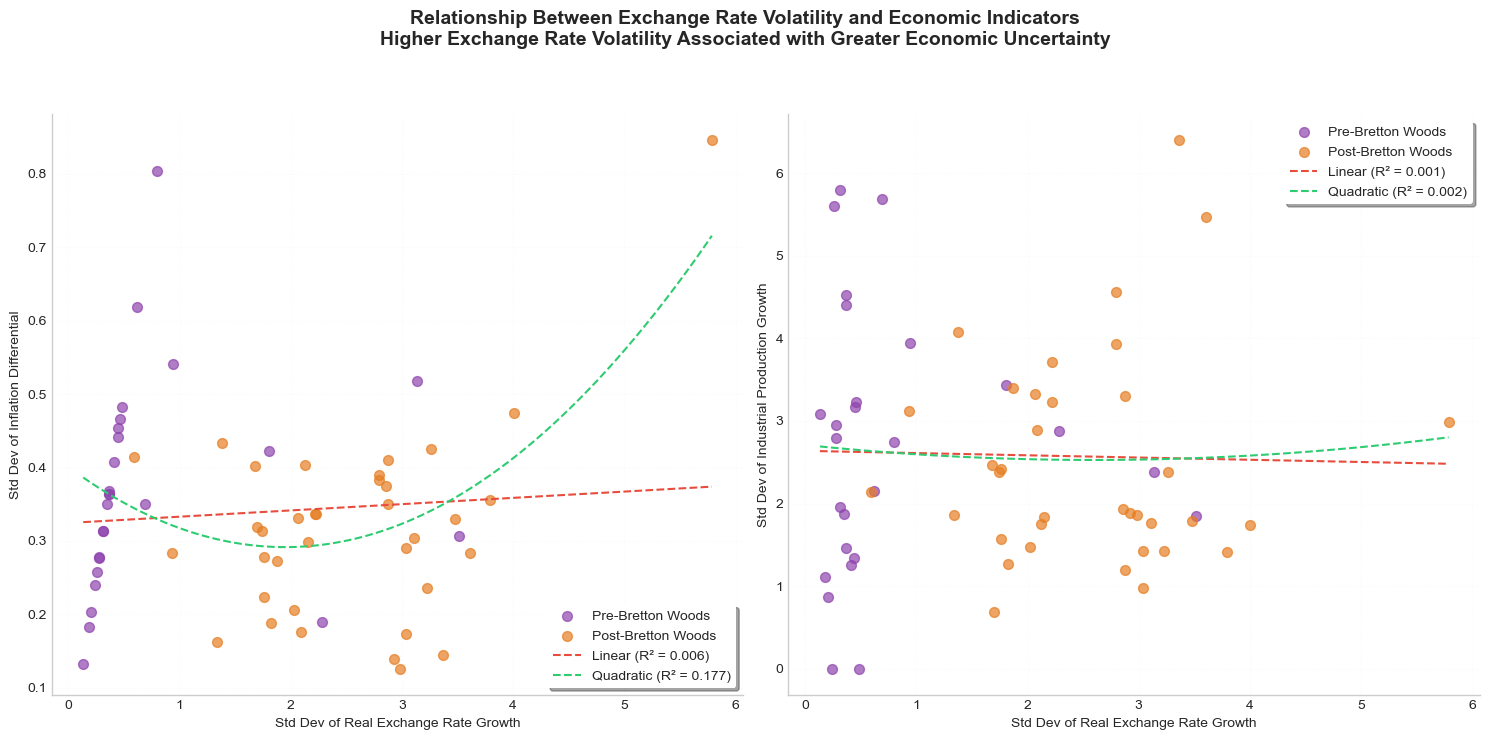

In [126]:
# Define Bretton Woods exit date
bretton_woods_exit = pd.to_datetime('1973-03-01')

# Prepare Variables
X_linear = sm.add_constant(reg_data['Real Exchange Rate Growth (%)'])
X_quad = pd.DataFrame({
    'const': 1,
    'x': reg_data['Real Exchange Rate Growth (%)'],
    'x2': reg_data['Real Exchange Rate Growth (%)']**2
})

# Run regressions
models = {}
for dep_var in ['Inflation_Differential', 'Industrial Production YoY Growth (%)']:
    models[f'{dep_var}_linear'] = sm.OLS(reg_data[dep_var], X_linear).fit()
    models[f'{dep_var}_quad'] = sm.OLS(reg_data[dep_var], X_quad).fit()

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.patch.set_facecolor('white')

# Colors
colors = {
    'pre_bw': '#8e44ad',      # Purple for pre-Bretton Woods
    'post_bw': '#e67e22',     # Orange for post-Bretton Woods
    'linear': '#e74c3c',      # Red for linear fit
    'quad': '#2ecc71',        # Green for quadratic fit
    'grid': '#ecf0f1'         # Light gray for grid
}

# Plot settings for both graphs
for ax in [ax1, ax2]:
    ax.grid(True, linestyle=':', alpha=0.3, color=colors['grid'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# X values for smooth curves
X_smooth = np.linspace(reg_data['Real Exchange Rate Growth (%)'].min(),
                      reg_data['Real Exchange Rate Growth (%)'].max(), 100)

# Create period masks
pre_bw = reg_data.index <= '1973-03'
post_bw = reg_data.index > '1973-03'

# Plot 1: Inflation Differential
y1 = reg_data['Inflation_Differential']
# Plot pre and post Bretton Woods points separately
ax1.scatter(reg_data[pre_bw]['Real Exchange Rate Growth (%)'], y1[pre_bw], 
            alpha=0.7, color=colors['pre_bw'], label='Pre-Bretton Woods',
            s=50)
ax1.scatter(reg_data[post_bw]['Real Exchange Rate Growth (%)'], y1[post_bw], 
            alpha=0.7, color=colors['post_bw'], label='Post-Bretton Woods',
            s=50)

# Add fits
ax1.plot(X_smooth, 
         models['Inflation_Differential_linear'].params.iloc[0] + 
         models['Inflation_Differential_linear'].params.iloc[1] * X_smooth,
         color=colors['linear'], linestyle='--', 
         label=f'Linear (R² = {models["Inflation_Differential_linear"].rsquared:.3f})')

X_quad_smooth = pd.DataFrame({'const': 1, 'x': X_smooth, 'x2': X_smooth**2})
ax1.plot(X_smooth,
         models['Inflation_Differential_quad'].predict(X_quad_smooth),
         color=colors['quad'], linestyle='--',
         label=f'Quadratic (R² = {models["Inflation_Differential_quad"].rsquared:.3f})')

ax1.set_xlabel('Std Dev of Real Exchange Rate Growth')
ax1.set_ylabel('Std Dev of Inflation Differential')
ax1.legend(frameon=True, facecolor='white', 
          edgecolor='none', shadow=True)

# Plot 2: Industrial Production
y2 = reg_data['Industrial Production YoY Growth (%)']
# Plot pre and post Bretton Woods points separately
ax2.scatter(reg_data[pre_bw]['Real Exchange Rate Growth (%)'], y2[pre_bw], 
            alpha=0.7, color=colors['pre_bw'], label='Pre-Bretton Woods',
            s=50)
ax2.scatter(reg_data[post_bw]['Real Exchange Rate Growth (%)'], y2[post_bw], 
            alpha=0.7, color=colors['post_bw'], label='Post-Bretton Woods',
            s=50)

# Add fits
ax2.plot(X_smooth,
         models['Industrial Production YoY Growth (%)_linear'].params.iloc[0] + 
         models['Industrial Production YoY Growth (%)_linear'].params.iloc[1] * X_smooth,
         color=colors['linear'], linestyle='--',
         label=f'Linear (R² = {models["Industrial Production YoY Growth (%)_linear"].rsquared:.3f})')

ax2.plot(X_smooth,
         models['Industrial Production YoY Growth (%)_quad'].predict(X_quad_smooth),
         color=colors['quad'], linestyle='--',
         label=f'Quadratic (R² = {models["Industrial Production YoY Growth (%)_quad"].rsquared:.3f})')

ax2.set_xlabel('Std Dev of Real Exchange Rate Growth')
ax2.set_ylabel('Std Dev of Industrial Production Growth')
ax2.legend(frameon=True, facecolor='white', 
          edgecolor='none', shadow=True)

# Main title
plt.suptitle('Relationship Between Exchange Rate Volatility and Economic Indicators\n' +
             'Higher Exchange Rate Volatility Associated with Greater Economic Uncertainty',
             fontsize=14, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()

plt.show()

## **Part 6**


In [127]:
df_UK = pd.read_excel('../data/imf_UK_data.xlsx')

In [128]:
# Rename the first column to 'Month'
df_UK.rename(columns={df_UK.columns[0]: 'Month'}, inplace=True)

# Rename the unnamed columns
df_UK.rename(columns={
    'Unnamed: 1': 'Industrial Production',
    'Unnamed: 2': 'Nominal Exchange Rate',
    'Unnamed: 3': 'International Reserves',
    'Unnamed: 4': 'CPI'
}, inplace=True)

# Delete the first two rows
df_UK = df_UK.drop([0, 1])

# Reset the index
df_UK.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
df_UK

,Month,Industrial Production,Nominal Exchange Rate,International Reserves,CPI
0,Dec 1959,47.7307,0.357143,2799.915,6.244479
1,Jan 1960,49.038263,0.357143,2763.97,6.22748
2,Feb 1960,50.790954,0.357143,2814.7,6.22748
3,Mar 1960,52.107791,0.357143,2968.795,6.216146
4,Apr 1960,48.602408,0.357143,2945.755,6.250146
...,...,...,...,...,...
488,Aug 2000,98.553379,0.67128,44575.08525,81.339005
489,Sep 2000,103.058048,0.6973,44384.430382,81.893841
490,Oct 2000,107.013368,0.68894,45959.397787,81.893841
491,Nov 2000,110.419337,0.70142,47948.094446,82.115776


In [129]:

pd.reset_option("display.max_rows")


In [130]:
# Ensure chronological order
df_UK = df_UK.sort_values("Month").reset_index(drop=True)

# Calculate Nominal Exchange Rate Growth (%)
df_UK["Nominal Exchange Rate Growth (%)"] = df_UK["Nominal Exchange Rate"].pct_change() * 100

# Calculate Real Exchange Rate Growth (%)
if "Real Exchange Rate" in df_UK.columns:
    df_UK["Real Exchange Rate Growth (%)"] = df_UK["Real Exchange Rate"].pct_change() * 100

# Calculate Real Exchange Rate Index (Base = 1 in Dec 1990)
dec_1990_value = df_UK.loc[df_UK["Month"] == "Dec 1990", "Nominal Exchange Rate"].values
if len(dec_1990_value) > 0:
    df_UK["Real Exchange Rate Index"] = df_UK["Nominal Exchange Rate"] / dec_1990_value[0]

# Calculate Monthly Inflation Growth (%)
df_UK["Monthly Inflation Growth (%)"] = df_UK["CPI"].pct_change() * 100

# Calculate Monthly Industrial Production Growth (%)
df_UK["Monthly Industrial Production Growth (%)"] = df_UK["Industrial Production"].pct_change() * 100

# Calculate Industrial Production YoY Growth (%) (12-month difference)
df_UK["Industrial Production YoY Growth (%)"] = df_UK["Industrial Production"].pct_change(periods=12) * 100

# Calculate International Reserves Index (Base = 100 in Jan 1960)
jan_1960_reserves = df_UK.loc[df_UK["Month"] == "Jan 1960", "International Reserves"].values
if len(jan_1960_reserves) > 0:
    df_UK["International Reserves Index"] = (df_UK["International Reserves"] / jan_1960_reserves[0]) * 100

# ✅ **Ensure No Rows Are Dropped!**
df_UK.loc[df_UK["Month"] == "Dec 1959", :]  # Check if Dec 1959 exists
df_UK.loc[df_UK["Month"] == "Jan 1960", :]  # Check if Jan 1960 exists

# **Fill NaNs to keep early rows**
df_UK = df_UK.fillna(method="ffill")  # Forward fill
df_UK = df_UK.fillna(method="bfill")  # Backward fill

df_UK


/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/432077746.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_UK["Nominal Exchange Rate Growth (%)"] = df_UK["Nominal Exchange Rate"].pct_change() * 100
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/432077746.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_UK["Monthly Inflation Growth (%)"] = df_UK["CPI"].pct_change() * 100
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/432077746.py:20: FutureWarning: Downcasting object dtype arrays on .fillna

,Month,Industrial Production,Nominal Exchange Rate,International Reserves,CPI,Nominal Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%),International Reserves Index
0,Apr 1960,48.602408,0.357143,2945.755000,6.250146,0.000000,0.688204,2.719842,3.606182,30.127838,106.576953
1,Apr 1961,50.355100,0.357143,3480.305001,6.420140,0.000000,0.688204,2.719842,3.606182,30.127838,125.916888
2,Apr 1962,49.038263,0.357143,3472.085000,6.784637,0.000000,0.688204,5.677408,-2.615101,30.127838,125.619489
3,Apr 1963,49.919245,0.357143,3341.870001,6.924458,0.000000,0.688204,2.060847,1.796520,30.127838,120.908331
4,Apr 1964,56.920737,0.357143,3202.545001,7.064279,0.000000,0.688204,2.019233,14.025636,30.127838,115.867575
...,...,...,...,...,...,...,...,...,...,...,...
488,Sep 1996,86.885711,0.641345,43248.706647,76.567413,-0.133827,1.235854,2.678571,0.516529,26.440592,1564.731406
489,Sep 1997,94.158579,0.625173,40071.297399,78.231922,-2.521612,1.204690,2.173913,8.370614,27.717126,1449.773239
490,Sep 1998,97.894159,0.595166,36740.630847,79.563529,-4.799774,1.146868,1.702128,3.967328,30.647705,1329.270247
491,Sep 1999,104.046878,0.616220,44362.713994,80.784169,3.537527,1.187438,1.534170,6.285073,34.368957,1605.036017


In [131]:
import pandas as pd

# Ensure Month column is in datetime format
df_UK["Month"] = pd.to_datetime(df_UK["Month"], format="%b %Y", errors="coerce")

# Check if any dates failed conversion (i.e., NaT values)
print("Missing date conversions:", df_UK["Month"].isna().sum())

# Sort by Month column in ascending order
df_UK = df_UK.sort_values("Month").reset_index(drop=True)

# Display first few rows to confirm Dec 1959 appears
print(df_UK.head())

df_UK


Missing date conversions: 0
       Month  Industrial Production  Nominal Exchange Rate  \
0 1959-12-01              47.730700               0.357143   
1 1960-01-01              49.038263               0.357143   
2 1960-02-01              50.790954               0.357143   
3 1960-03-01              52.107791               0.357143   
4 1960-04-01              48.602408               0.357143   

   International Reserves       CPI  Nominal Exchange Rate Growth (%)  \
0                2799.915  6.244479                        -46.796717   
1                2763.970  6.227480                        -42.856206   
2                2814.700  6.227480                        -47.805951   
3                2968.795  6.216146                        -46.142026   
4                2945.755  6.250146                          0.000000   

   Real Exchange Rate Index  Monthly Inflation Growth (%)  \
0                  0.688204                    -92.322898   
1                  0.688204           

,Month,Industrial Production,Nominal Exchange Rate,International Reserves,CPI,Nominal Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%),International Reserves Index
0,1959-12-01,47.730700,0.357143,2799.915000,6.244479,-46.796717,0.688204,-92.322898,-51.568683,-36.846626,101.300484
1,1960-01-01,49.038263,0.357143,2763.970000,6.227480,-42.856206,0.688204,-92.291213,-51.643562,-39.496568,100.000000
2,1960-02-01,50.790954,0.357143,2814.700000,6.227480,-47.805951,0.688204,-92.416220,-49.915240,-36.091015,101.835403
3,1960-03-01,52.107791,0.357143,2968.795000,6.216146,-46.142026,0.688204,-92.388880,-49.918929,-35.264977,107.410536
4,1960-04-01,48.602408,0.357143,2945.755000,6.250146,0.000000,0.688204,2.719842,3.606182,30.127838,106.576953
...,...,...,...,...,...,...,...,...,...,...,...
488,2000-08-01,98.553379,0.671280,44575.085250,81.339005,7.870802,1.293538,0.964187,5.653710,34.015397,1612.719575
489,2000-09-01,103.058048,0.697300,44384.430382,81.893841,13.157639,1.343677,1.373626,-0.950370,24.169590,1605.821712
490,2000-10-01,107.013368,0.688940,45959.397787,81.893841,14.252073,1.327568,1.373626,3.506908,27.229293,1662.803785
491,2000-11-01,110.419337,0.701420,47948.094446,82.115776,13.861338,1.351616,1.508916,1.617796,25.073285,1734.754518


In [132]:
df_UK.drop(columns=["Industrial Production", "CPI"], errors="ignore", inplace=True)
df_UK["Country"] = "UK"
df_UK["Real Exchange Rate Growth (%)"] = df_UK["Real Exchange Rate Index"].pct_change() * 100
df_UK.rename(columns={"Month": "Date"}, inplace=True)

# Define the correct column order
column_order = [
    "Date",
    "Country",
    "Nominal Exchange Rate",
    "International Reserves Index",
    "Nominal Exchange Rate Growth (%)",
    "Real Exchange Rate Growth (%)",
    "Real Exchange Rate Index",
    "Monthly Inflation Growth (%)",
    "Monthly Industrial Production Growth (%)",
    "Industrial Production YoY Growth (%)"
]

# Reorder the columns
df_UK = df_UK[column_order]



In [133]:
df_UK

,Date,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,1959-12-01,UK,0.357143,101.300484,-46.796717,NaN,0.688204,-92.322898,-51.568683,-36.846626
1,1960-01-01,UK,0.357143,100.000000,-42.856206,0.000000,0.688204,-92.291213,-51.643562,-39.496568
2,1960-02-01,UK,0.357143,101.835403,-47.805951,0.000000,0.688204,-92.416220,-49.915240,-36.091015
3,1960-03-01,UK,0.357143,107.410536,-46.142026,0.000000,0.688204,-92.388880,-49.918929,-35.264977
4,1960-04-01,UK,0.357143,106.576953,0.000000,0.000000,0.688204,2.719842,3.606182,30.127838
...,...,...,...,...,...,...,...,...,...,...
488,2000-08-01,UK,0.671280,1612.719575,7.870802,1.258032,1.293538,0.964187,5.653710,34.015397
489,2000-09-01,UK,0.697300,1605.821712,13.157639,3.876177,1.343677,1.373626,-0.950370,24.169590
490,2000-10-01,UK,0.688940,1662.803785,14.252073,-1.198910,1.327568,1.373626,3.506908,27.229293
491,2000-11-01,UK,0.701420,1734.754518,13.861338,1.811479,1.351616,1.508916,1.617796,25.073285


In [134]:
# Ensure column names and order are consistent
df_UK = df_UK[merged_df.columns]

# Merge UK data with existing merged_df (Germany & US data)
final_merged_df = pd.concat([merged_df, df_UK], ignore_index=True)

# Sort by Date first, then by Country (keeping Germany first, then US, then UK)
final_merged_df["Country"] = pd.Categorical(final_merged_df["Country"], categories=["Germany", "US", "UK"], ordered=True)
final_merged_df = final_merged_df.sort_values(["Date", "Country"]).reset_index(drop=True)

# Display final merged DataFrame
final_merged_df


,Date,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,1959-12-01,Germany,4.200000,101.848342,0.000000,-0.340136,1.713301,0.000000,-4.019729,10.900123
1,1959-12-01,US,2.938981,100.122916,NaN,NaN,NaN,-0.340136,NaN,NaN
2,1959-12-01,UK,0.357143,101.300484,-46.796717,NaN,0.688204,-92.322898,-51.568683,-36.846626
3,1960-01-01,Germany,4.200000,100.000000,0.000000,-0.340136,1.707474,0.000000,-4.019729,10.900123
4,1960-01-01,US,2.938981,100.000000,NaN,NaN,NaN,-0.340136,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1234,2000-08-01,UK,0.671280,1612.719575,7.870802,1.258032,1.293538,0.964187,5.653710,34.015397
1235,2000-09-01,UK,0.697300,1605.821712,13.157639,3.876177,1.343677,1.373626,-0.950370,24.169590
1236,2000-10-01,UK,0.688940,1662.803785,14.252073,-1.198910,1.327568,1.373626,3.506908,27.229293
1237,2000-11-01,UK,0.701420,1734.754518,13.861338,1.811479,1.351616,1.508916,1.617796,25.073285


In [135]:
# Ensure "Country" is categorical with the correct order
final_merged_df["Country"] = pd.Categorical(
    final_merged_df["Country"], 
    categories=["Germany", "US", "UK"], 
    ordered=True
)

# Sort by Country first (to ensure order), then by Date
final_merged_df = final_merged_df.sort_values(by=["Country", "Date"]).reset_index(drop=True)

# Display sorted DataFrame
final_merged_df



,Date,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,1959-12-01,Germany,4.20000,101.848342,0.000000,-0.340136,1.713301,0.000000,-4.019729,10.900123
1,1960-01-01,Germany,4.20000,100.000000,0.000000,-0.340136,1.707474,0.000000,-4.019729,10.900123
2,1960-02-01,Germany,4.20000,101.740143,0.000000,0.914640,1.723091,-0.568147,-0.488181,10.900123
3,1960-03-01,Germany,4.20000,105.128964,0.000000,0.000000,1.723091,0.000000,3.743868,10.900123
4,1960-04-01,Germany,4.20000,110.837171,0.000000,-0.229943,1.719129,0.571393,6.470881,10.900123
...,...,...,...,...,...,...,...,...,...,...
1234,2000-08-01,UK,0.67128,1612.719575,7.870802,1.258032,1.293538,0.964187,5.653710,34.015397
1235,2000-09-01,UK,0.69730,1605.821712,13.157639,3.876177,1.343677,1.373626,-0.950370,24.169590
1236,2000-10-01,UK,0.68894,1662.803785,14.252073,-1.198910,1.327568,1.373626,3.506908,27.229293
1237,2000-11-01,UK,0.70142,1734.754518,13.861338,1.811479,1.351616,1.508916,1.617796,25.073285


In [136]:
df_UK['Period'] = pd.cut(
    df_UK['Date'],
    bins=pd.to_datetime(["1959-12-01", "1990-10-01", "1992-10-01", "2000-12-01"]),
    labels=["Pre-ERM", "During ERM", "Post-ERM"]
)

volatility = df_UK.groupby("Period")["Real Exchange Rate Growth (%)"].std()
print ("Volatility of Real Exchange Rate Growth (%) by Period:")
print(volatility)


Volatility of Real Exchange Rate Growth (%) by Period:
Period
Pre-ERM       2.206149
During ERM    3.749104
Post-ERM      2.011344
Name: Real Exchange Rate Growth (%), dtype: float64


/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/2590394240.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volatility = df_UK.groupby("Period")["Real Exchange Rate Growth (%)"].std()


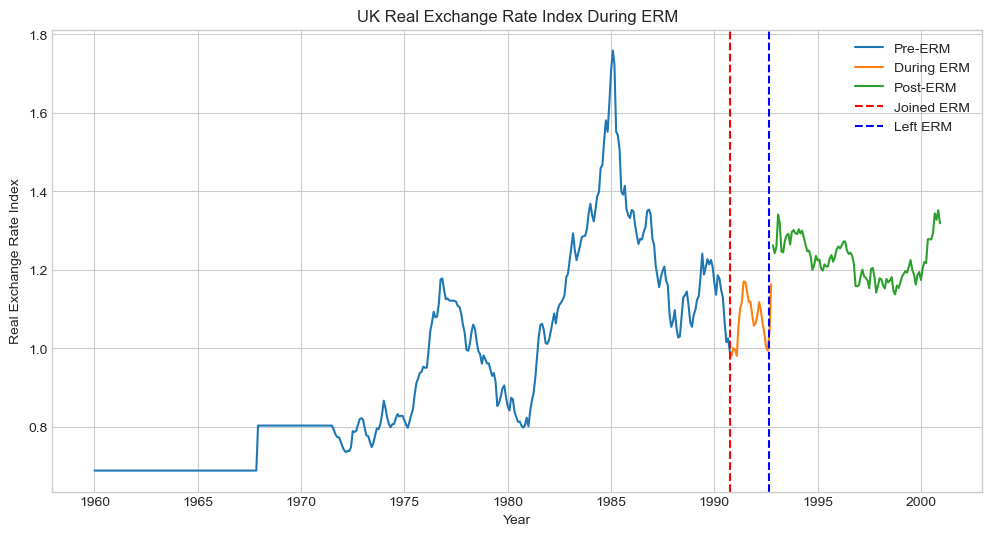

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for period in ["Pre-ERM", "During ERM", "Post-ERM"]:
    subset = df_UK[df_UK["Period"] == period]
    plt.plot(subset["Date"], subset["Real Exchange Rate Index"], label=period)

plt.axvline(pd.to_datetime("1990-10-01"), color='red', linestyle="--", label="Joined ERM")
plt.axvline(pd.to_datetime("1992-09-01"), color='blue', linestyle="--", label="Left ERM")
plt.legend()
plt.title("UK Real Exchange Rate Index During ERM")
plt.xlabel("Year")
plt.ylabel("Real Exchange Rate Index")
plt.show()


In [138]:
inflation_trend = df_UK.groupby("Period")["Monthly Inflation Growth (%)"].mean()
production_trend = df_UK.groupby("Period")["Industrial Production YoY Growth (%)"].mean()

print("Average Monthly Inflation Growth by Period:")
print(inflation_trend)

print("Average Industrial Production YoY Growth by Period:")
print(production_trend)


Average Monthly Inflation Growth by Period:
Period
Pre-ERM       5.268933
During ERM    6.547014
Post-ERM      2.182932
Name: Monthly Inflation Growth (%), dtype: float64
Average Industrial Production YoY Growth by Period:
Period
Pre-ERM       -0.547895
During ERM    10.864590
Post-ERM      28.754061
Name: Industrial Production YoY Growth (%), dtype: float64


/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/2763431715.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  inflation_trend = df_UK.groupby("Period")["Monthly Inflation Growth (%)"].mean()
/var/folders/16/ybdglc7d23vfl64gx8z5bp6m0000gn/T/ipykernel_47510/2763431715.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  production_trend = df_UK.groupby("Period")["Industrial Production YoY Growth (%)"].mean()


Unique countries in final_merged_df: ['Germany', 'US', 'UK']
Categories (3, object): ['Germany' < 'US' < 'UK']
Pivoted DataFrame Columns: MultiIndex([(        'Monthly Inflation Growth (%)', 'Germany'),
            (        'Monthly Inflation Growth (%)',      'US'),
            (        'Monthly Inflation Growth (%)',      'UK'),
            ('Industrial Production YoY Growth (%)', 'Germany'),
            ('Industrial Production YoY Growth (%)',      'US'),
            ('Industrial Production YoY Growth (%)',      'UK')],
           names=[None, 'Country'])
Flattened Column Names: Index(['Monthly Inflation Growth (%)_Germany',
       'Monthly Inflation Growth (%)_US', 'Monthly Inflation Growth (%)_UK',
       'Industrial Production YoY Growth (%)_Germany',
       'Industrial Production YoY Growth (%)_US',
       'Industrial Production YoY Growth (%)_UK'],
      dtype='object')


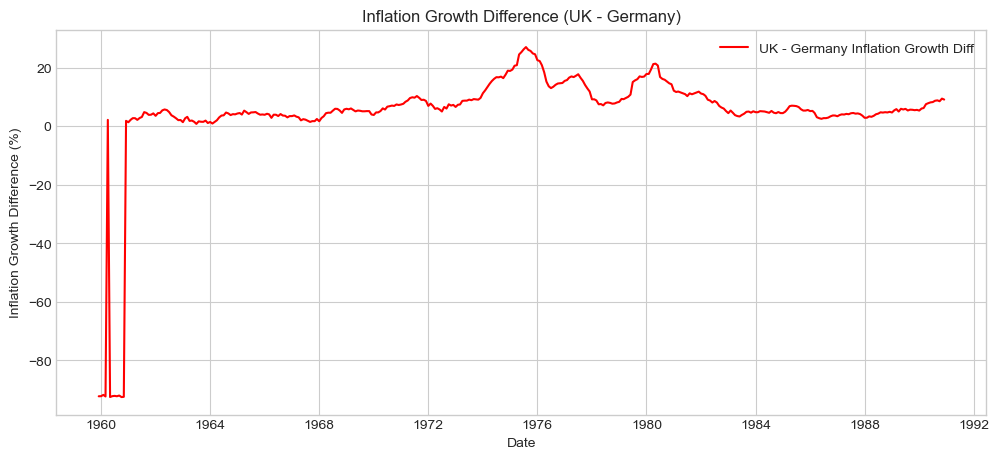

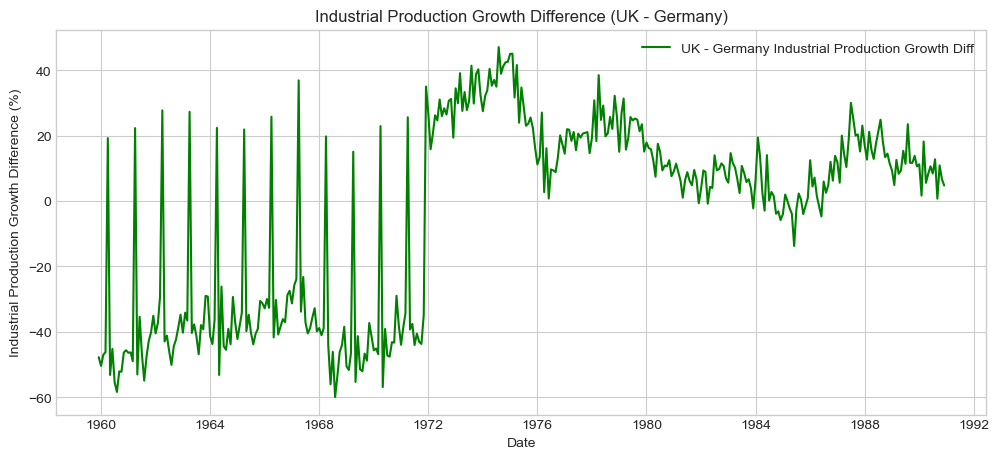

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure UK data is present in final_merged_df
print("Unique countries in final_merged_df:", final_merged_df["Country"].unique())

if "UK" not in final_merged_df["Country"].unique():
    print("Error: UK data is missing from final_merged_df. Check previous merging steps.")

# Pivot dataframe to have inflation and industrial production in separate columns for each country
comparison_pivot = final_merged_df.pivot(index="Date", columns="Country", values=["Monthly Inflation Growth (%)", "Industrial Production YoY Growth (%)"])

# Print column names to check if UK is included
print("Pivoted DataFrame Columns:", comparison_pivot.columns)

# If UK is not found, stop execution
if "UK" not in comparison_pivot.columns.get_level_values(1):
    raise ValueError("UK data is missing in pivoted DataFrame. Check data source.")

# Drop NaN values only where all columns are missing
comparison_pivot = comparison_pivot.dropna(how="all")

# Flatten MultiIndex column names
comparison_pivot.columns = ['_'.join(col).strip() for col in comparison_pivot.columns]
print("Flattened Column Names:", comparison_pivot.columns)

# Ensure necessary columns exist before computing differences
if "Monthly Inflation Growth (%)_UK" in comparison_pivot.columns and "Monthly Inflation Growth (%)_Germany" in comparison_pivot.columns:
    # Compute inflation growth difference
    comparison_pivot["Inflation Diff (UK - Germany)"] = (
        comparison_pivot["Monthly Inflation Growth (%)_UK"] - comparison_pivot["Monthly Inflation Growth (%)_Germany"]
    )
else:
    raise ValueError("UK or Germany inflation data is missing after pivoting.")

if "Industrial Production YoY Growth (%)_UK" in comparison_pivot.columns and "Industrial Production YoY Growth (%)_Germany" in comparison_pivot.columns:
    # Compute industrial production growth difference
    comparison_pivot["Industrial Production Diff (UK - Germany)"] = (
        comparison_pivot["Industrial Production YoY Growth (%)_UK"] - comparison_pivot["Industrial Production YoY Growth (%)_Germany"]
    )
else:
    raise ValueError("UK or Germany industrial production data is missing after pivoting.")

# Reset index for standard DataFrame format
comparison_pivot = comparison_pivot.reset_index()

# Plot Inflation Growth Difference
plt.figure(figsize=(12, 5))
plt.plot(comparison_pivot["Date"], comparison_pivot["Inflation Diff (UK - Germany)"], label="UK - Germany Inflation Growth Diff", color="red")
plt.legend()
plt.title("Inflation Growth Difference (UK - Germany)")
plt.xlabel("Date")
plt.ylabel("Inflation Growth Difference (%)")
plt.show()

# Plot Industrial Production Growth Difference
plt.figure(figsize=(12, 5))
plt.plot(comparison_pivot["Date"], comparison_pivot["Industrial Production Diff (UK - Germany)"], label="UK - Germany Industrial Production Growth Diff", color="green")
plt.legend()
plt.title("Industrial Production Growth Difference (UK - Germany)")
plt.xlabel("Date")
plt.ylabel("Industrial Production Growth Difference (%)")
plt.show()


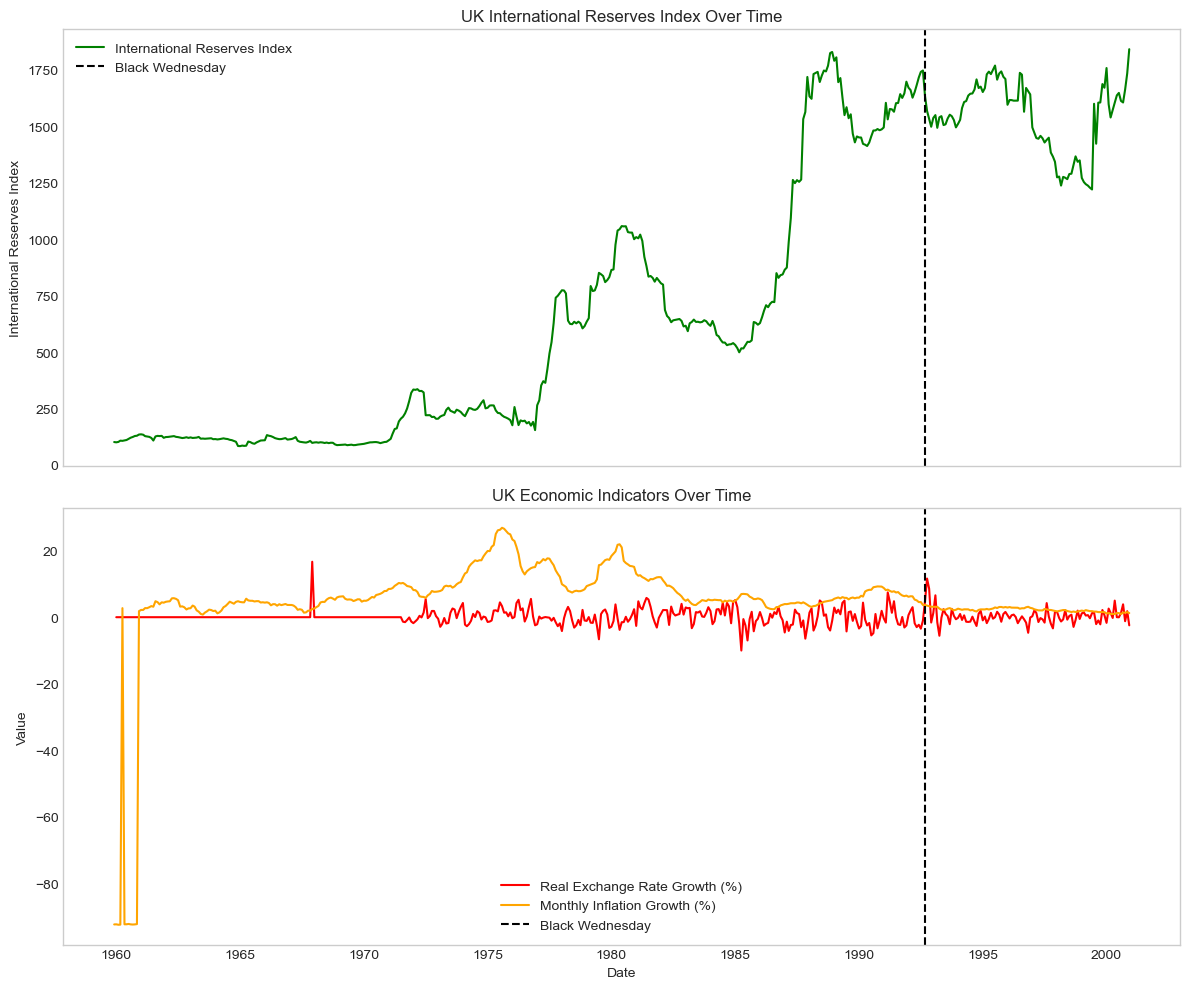

In [140]:
# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot International Reserves Index separately
ax[0].plot(df_UK["Date"], df_UK["International Reserves Index"], label="International Reserves Index", color="green")
ax[0].axvline(pd.to_datetime("1992-09-01"), color="black", linestyle="--", label="Black Wednesday")
ax[0].set_title("UK International Reserves Index Over Time")
ax[0].set_ylabel("International Reserves Index")
ax[0].legend()
ax[0].grid()

# Plot all other indicators on the second subplot
ax[1].plot(df_UK["Date"], df_UK["Real Exchange Rate Growth (%)"], label="Real Exchange Rate Growth (%)", color="red")
ax[1].plot(df_UK["Date"], df_UK["Monthly Inflation Growth (%)"], label="Monthly Inflation Growth (%)", color="orange")
ax[1].axvline(pd.to_datetime("1992-09-01"), color="black", linestyle="--", label="Black Wednesday")
ax[1].set_title("UK Economic Indicators Over Time")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Value")
ax[1].legend()
ax[1].grid()

# Display the plots
plt.tight_layout()
plt.show()
